In [1]:
import os
import PIL
import numpy as np
from joblib import Parallel, delayed
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import single_cell_reloc_paraquet.global_functions.global_variables as gv

In [2]:
###############################< Code used from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=0):
	vect_shape = vector.shape[:2]
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=False):
	image_src = cv2.imread(image_file)
	if gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)
	else:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)

	cv2.imwrite(image_file, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder
	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

images = ['list']
vector = (-183,37)

def miniImgIndex():
	def f_Frame(z):
		start = z.find('_time')+5
		end = z.find('_time')+9
		return(z[start:end])

	count = 0
	mini_imgIndex = []
	for root, dirs, files in os.walk(os.getcwd()):
		for name in files:
			if name.endswith(".tif"):
				mini_imgIndex.append({'Path': os.path.join(root, name)})
				count = count + 1
				print(count, end="/r")
			else :
				pass

	mini_imgIndex = pd.DataFrame(mini_imgIndex)
	mini_imgIndex['Frame'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_Frame)
	mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lambda x: os.path.basename(x).split('/')[-1])

	return(mini_imgIndex)


i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0011.tif"
translate_this(image_file=i, at =vector, with_plot=True)

if __name__ == "__main__":
	vector = input('What are the vector aspects {x, y}').split(, )
	stop = int(input("What is the max frame to be shift"))
	folder = input("Where is the directory to be done?")
	folder = gv.slash_switch(folder)
	parallel_state = input("Should the files be shifted in parallel? [y/n]")
	if parallel_state == "y" or parallel_state == "yes" or parallel_state =="Y" or parallel_state == "Yes" or parallel_state == "YES":
		parallel_state = True
	else:
		parallel_state = False
	os.chdir(folder)
	use_cores_len = os.cpu_count()
	mini_imgIndex = miniImgIndex() #* Run search in current folder
	miniImgIndex_subset = mini_imgIndex.loc[mini_imgIndex['Frame']>= stop]

	if parallel_state:
		Parallel(n_jobs=use_cores_len, verbose = 100, prefer='threads')(delayed(translate_this)(image_file = i, at = vector, with_plot=False, gray_scale=True) for i in mini_imgIndex['File_name']) #* This should prefer threads as it largely IO limited.
	else:
		for i in mini_imgIndex['File_name']:
			translate_this(image_file= i, at = vector, with_plot=False, gray_scale=True )

SyntaxError: invalid syntax (<ipython-input-2-d0eead1ee35f>, line 118)

In [3]:
###############################< Code used from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=0):
	vect_shape = vector.shape[:2]
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=False):
	image_src = cv2.imread(image_file)
	if gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)
	else:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)

	cv2.imwrite(image_file, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder
	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

ValueError: invalid literal for int() with base 10: ''

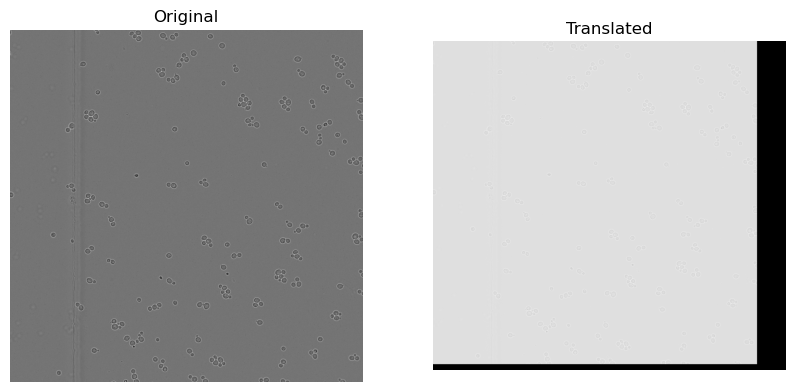

In [4]:
images = ['list']
vector = (-183,37)

def miniImgIndex():
	def f_Frame(z):
		start = z.find('_time')+5
		end = z.find('_time')+9
		return(z[start:end])

	count = 0
	mini_imgIndex = []
	for root, dirs, files in os.walk(os.getcwd()):
		for name in files:
			if name.endswith(".tif"):
				mini_imgIndex.append({'Path': os.path.join(root, name)})
				count = count + 1
				print(count, end="/r")
			else :
				pass

	mini_imgIndex = pd.DataFrame(mini_imgIndex)
	mini_imgIndex['Frame'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_Frame)
	mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lambda x: os.path.basename(x).split('/')[-1])

	return(mini_imgIndex)


i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0011.tif"
translate_this(image_file=i, at =vector, with_plot=True)

if __name__ == "__main__":
	vector = input('What are the vector aspects {x, y}').split(sep= ", ")
	stop = int(input("What is the max frame to be shift"))
	folder = input("Where is the directory to be done?")
	folder = gv.slash_switch(folder)
	parallel_state = input("Should the files be shifted in parallel? [y/n]")
	if parallel_state == "y" or parallel_state == "yes" or parallel_state =="Y" or parallel_state == "Yes" or parallel_state == "YES":
		parallel_state = True
	else:
		parallel_state = False
	os.chdir(folder)
	use_cores_len = os.cpu_count()
	mini_imgIndex = miniImgIndex() #* Run search in current folder
	miniImgIndex_subset = mini_imgIndex.loc[mini_imgIndex['Frame']>= stop]

	if parallel_state:
		Parallel(n_jobs=use_cores_len, verbose = 100, prefer='threads')(delayed(translate_this)(image_file = i, at = vector, with_plot=False, gray_scale=True) for i in mini_imgIndex['File_name']) #* This should prefer threads as it largely IO limited.
	else:
		for i in mini_imgIndex['File_name']:
			translate_this(image_file= i, at = vector, with_plot=False, gray_scale=True )

In [5]:
vector = input('What are the vector aspects {x, y}').split(sep= ", ")

In [6]:
vector

['-184', '30']

In [7]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0011.tif"
translate_this(image_file=i, at =vector, with_plot=True)

TypeError: bad operand type for abs(): 'str'

In [8]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0011.tif"
translate_this(image_file=i, at = (vector[0], vector[1]), with_plot=True)

TypeError: bad operand type for abs(): 'str'

In [9]:
vector = int(input('What are the vector aspects {x, y}').split(sep= ", "))

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

In [10]:
vector

['-184', '30']

In [11]:
vector[0] = int(vector[0])
vector[1] = int(vector[1])

In [12]:
vector

[-184, 30]

In [13]:
type(vector)

list

In [14]:
type(vector[0])

int

True

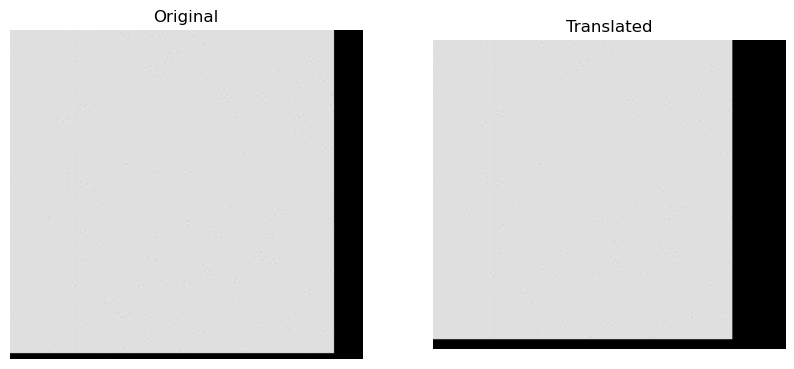

In [15]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0011.tif"
translate_this(image_file=i, at =vector, with_plot=True)


In [16]:
iamge_file = "Sub_position090200_time0011.tif"

In [17]:
dot = image_file.find(".")
name = image_file[:dot]
image_ext = image_file[dot+1:]

NameError: name 'image_file' is not defined

In [18]:
image_file = "Sub_position090200_time0011.tif"

In [19]:
dot = image_file.find(".")
name = image_file[:dot]
image_ext = image_file[dot+1:]

In [20]:
image_ext

'tif'

In [21]:
dot = image_file.find(".")
name = image_file[:dot]
image_ext = image_file[dot:]

In [22]:
name

'Sub_position090200_time0011'

In [23]:
image_ext

'.tif'

In [24]:
###############################< Code used from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=0):
	vect_shape = vector.shape[:2]
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=False):
	image_src = cv2.imread(image_file)
	if gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)
	else:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)

	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext
	cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder
	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

In [25]:
images = ['list']
vector = (-183,37)

def miniImgIndex():
	def f_Frame(z):
		start = z.find('_time')+5
		end = z.find('_time')+9
		return(z[start:end])

	count = 0
	mini_imgIndex = []
	for root, dirs, files in os.walk(os.getcwd()):
		for name in files:
			if name.endswith(".tif"):
				mini_imgIndex.append({'Path': os.path.join(root, name)})
				count = count + 1
				print(count, end="/r")
			else :
				pass

	mini_imgIndex = pd.DataFrame(mini_imgIndex)
	mini_imgIndex['Frame'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_Frame)
	mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lambda x: os.path.basename(x).split('/')[-1])

	return(mini_imgIndex)


# i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0011.tif"
# translate_this(image_file=i, at =vector, with_plot=True)

if __name__ == "__main__":
	vector = input('What are the vector aspects {x, y}').split(sep= ", ")
	vector[0] = int(vector[0])
	vector[1] = int(vector[1])
	stop = int(input("What is the max frame to be shift"))
	folder = input("Where is the directory to be done?")
	folder = gv.slash_switch(folder)
	parallel_state = input("Should the files be shifted in parallel? [y/n]")
	if parallel_state == "y" or parallel_state == "yes" or parallel_state =="Y" or parallel_state == "Yes" or parallel_state == "YES":
		parallel_state = True
	else:
		parallel_state = False
	os.chdir(folder)
	use_cores_len = os.cpu_count()
	mini_imgIndex = miniImgIndex() #* Run search in current folder
	miniImgIndex_subset = mini_imgIndex.loc[mini_imgIndex['Frame']>= stop]

	if parallel_state:
		Parallel(n_jobs=use_cores_len, verbose = 100, prefer='threads')(delayed(translate_this)(image_file = i, at = vector, with_plot=False, gray_scale=True) for i in mini_imgIndex['File_name']) #* This should prefer threads as it largely IO limited.
	else:
		for i in mini_imgIndex['File_name']:
			translate_this(image_file= i, at = vector, with_plot=False, gray_scale=True )

ValueError: invalid literal for int() with base 10: '-182.6'

In [26]:
images = ['list']
vector = (-183,37)

def miniImgIndex():
	def f_Frame(z):
		start = z.find('_time')+5
		end = z.find('_time')+9
		return(z[start:end])

	count = 0
	mini_imgIndex = []
	for root, dirs, files in os.walk(os.getcwd()):
		for name in files:
			if name.endswith(".tif"):
				mini_imgIndex.append({'Path': os.path.join(root, name)})
				count = count + 1
				print(count, end="/r")
			else :
				pass

	mini_imgIndex = pd.DataFrame(mini_imgIndex)
	mini_imgIndex['Frame'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_Frame)
	mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lambda x: os.path.basename(x).split('/')[-1])

	return(mini_imgIndex)


# i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0011.tif"
# translate_this(image_file=i, at =vector, with_plot=True)

if __name__ == "__main__":
	vector = input('What are the vector aspects {x, y}').split(sep= ", ")
	vector[0] = int(vector[0])
	vector[1] = int(vector[1])
	stop = int(input("What is the max frame to be shift"))
	folder = input("Where is the directory to be done?")
	folder = gv.slash_switch(folder)
	parallel_state = input("Should the files be shifted in parallel? [y/n]")
	if parallel_state == "y" or parallel_state == "yes" or parallel_state =="Y" or parallel_state == "Yes" or parallel_state == "YES":
		parallel_state = True
	else:
		parallel_state = False
	os.chdir(folder)
	use_cores_len = os.cpu_count()
	mini_imgIndex = miniImgIndex() #* Run search in current folder
	miniImgIndex_subset = mini_imgIndex.loc[mini_imgIndex['Frame']>= stop]

	if parallel_state:
		Parallel(n_jobs=use_cores_len, verbose = 100, prefer='threads')(delayed(translate_this)(image_file = i, at = vector, with_plot=False, gray_scale=True) for i in mini_imgIndex['File_name']) #* This should prefer threads as it largely IO limited.
	else:
		for i in mini_imgIndex['File_name']:
			translate_this(image_file= i, at = vector, with_plot=False, gray_scale=True )

InvalidIndexError: (slice(None, None, None), 0)

In [27]:
mini_imgIndex

NameError: name 'mini_imgIndex' is not defined

In [28]:
mini_imgIndex = miniImgIndex()

InvalidIndexError: (slice(None, None, None), 0)

In [29]:
os.getcwd()

"C:\\Users\\pcnba\\Grant Brown's Lab Dropbox\\Peter Bartlett\\Peter Bartlett Data\\Testing_shift_fix\\Images"

In [30]:
def f_Frame(z):
	start = z.find('_time')+5
	end = z.find('_time')+9
	return(z[start:end])

count = 0
mini_imgIndex = []
for root, dirs, files in os.walk(os.getcwd()):
	for name in files:
		if name.endswith(".tif"):
			mini_imgIndex.append({'Path': os.path.join(root, name)})
			count = count + 1
			print(count, end="/r")
		else :
			pass
del dirs

mini_imgIndex = pd.DataFrame(mini_imgIndex)
mini_imgIndex['Frame'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_Frame)

In [31]:
mini_imgIndex

Path Frame
0   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0011
1   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0012
2   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0013
3   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0014
4   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0015
5   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0016
6   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0017
7   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0018
8   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0019
9   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0020
10  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0021
11  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0022
12  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0023
13  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0024
14  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0025
15  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0026
16  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0027
17  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0028
18  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0029
19  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0030
20  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0031
21  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0032
22  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0033
23  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0034
24  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0035
25  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0036
26  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0037
27  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0038
28  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0039
29  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0040
30  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0041
31  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0042
32  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0043
33  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0044
34  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0045
35  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0046
36  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0047
37  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0048
38  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0049
39  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0050
40  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0051
41  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0052
42  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0053
43  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0054
44  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0055
45  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0056
46  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  0057

In [32]:
def f_Frame_int(z):
	start = z.find('_time')+5
	end = z.find('_time')+9
	return(int(z[start:end])) #* This is a modification of normal string returned version

count = 0
mini_imgIndex = []
for root, dirs, files in os.walk(os.getcwd()):
	for name in files:
		if name.endswith(".tif"):
			mini_imgIndex.append({'Path': os.path.join(root, name)})
			count = count + 1
			print(count, end="/r")
		else :
			pass
del dirs

mini_imgIndex = pd.DataFrame(mini_imgIndex)
mini_imgIndex['Frame'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_Frame_int)

In [33]:
mini_imgIndex

Path  Frame
0   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     11
1   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     12
2   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     13
3   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     14
4   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     15
5   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     16
6   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     17
7   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     18
8   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     19
9   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     20
10  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     21
11  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     22
12  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     23
13  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     24
14  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     25
15  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     26
16  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     27
17  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     28
18  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     29
19  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     30
20  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     31
21  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     32
22  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     33
23  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     34
24  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     35
25  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     36
26  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     37
27  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     38
28  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     39
29  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     40
30  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     41
31  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     42
32  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     43
33  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     44
34  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     45
35  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     46
36  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     47
37  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     48
38  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     49
39  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     50
40  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     51
41  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     52
42  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     53
43  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     54
44  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     55
45  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     56
46  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     57

In [34]:
mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lambda x: os.path.basename(x).split('/')[-1])

InvalidIndexError: (slice(None, None, None), 0)

In [35]:
mat = [[random.randint(5, 100) for i in range(5)] for j in range(5)]
mat = np.matrix(mat)

NameError: name 'random' is not defined

In [36]:
import random

In [37]:
mat = [[random.randint(5, 100) for i in range(5)] for j in range(5)]
mat = np.matrix(mat)

In [38]:
mat

matrix([[25, 95, 31, 45, 72],
        [16, 93, 82, 87, 28],
        [67, 92, 21, 41, 20],
        [10, 72, 72, 16, 43],
        [36, 91, 82, 49, 40]])

In [39]:
pmat = pad_vector(vector=mat, how='left', depth=3)

In [40]:
pmat

matrix([[ 0,  0,  0, 25, 95, 31, 45, 72],
        [ 0,  0,  0, 16, 93, 82, 87, 28],
        [ 0,  0,  0, 67, 92, 21, 41, 20],
        [ 0,  0,  0, 10, 72, 72, 16, 43],
        [ 0,  0,  0, 36, 91, 82, 49, 40]])

In [41]:
pmat[3:]

matrix([[ 0,  0,  0, 10, 72, 72, 16, 43],
        [ 0,  0,  0, 36, 91, 82, 49, 40]])

In [42]:
pmat[,3:]

SyntaxError: invalid syntax (<ipython-input-42-9ff4b8c23d34>, line 1)

In [43]:
pmat[:,3:]

matrix([[25, 95, 31, 45, 72],
        [16, 93, 82, 87, 28],
        [67, 92, 21, 41, 20],
        [10, 72, 72, 16, 43],
        [36, 91, 82, 49, 40]])

In [44]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=0):
	vect_shape = vector.shape[:2]
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv



def read_this(image_file, gray_scale=False):
	image_src = cv2.imread(image_file)
	# if gray_scale:
	# 	image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)
	# else:
	# 	image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)

	image_trans =

	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext
	cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder
	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

SyntaxError: invalid syntax (<ipython-input-44-fbcf3a05ab38>, line 71)

In [45]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=0):
	vect_shape = vector.shape[:2]
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv



def read_this(image_file, gray_scale=False):
	image_src = cv2.imread(image_file)
	# if gray_scale:
	# 	image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)
	# else:
	# 	image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)

	# image_trans =

	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext
	cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder
	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

In [46]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0011.tif"
translate_this(image_file=i, at =vector, with_plot=True)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [47]:
image_src = read_this(image_file=image_file, gray_scale=gray_scale)


NameError: name 'gray_scale' is not defined

In [48]:
image_src = read_this(image_file=i, gray_scale=True)


In [49]:
image_src

array([[[128, 128, 128],
        [127, 127, 127],
        [127, 127, 127],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[128, 128, 128],
        [127, 127, 127],
        [127, 127, 127],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[128, 128, 128],
        [127, 127, 127],
        [127, 127, 127],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [50]:
ax1.imshow(image_src, cmap=cmap_val)

NameError: name 'ax1' is not defined

In [51]:
imshow(image_src, cmap=cmap_val)

NameError: name 'imshow' is not defined

In [52]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=0):
	vect_shape = vector.shape[:2]
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=False):
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)

	# image_trans =

	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext
	cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder
	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

True

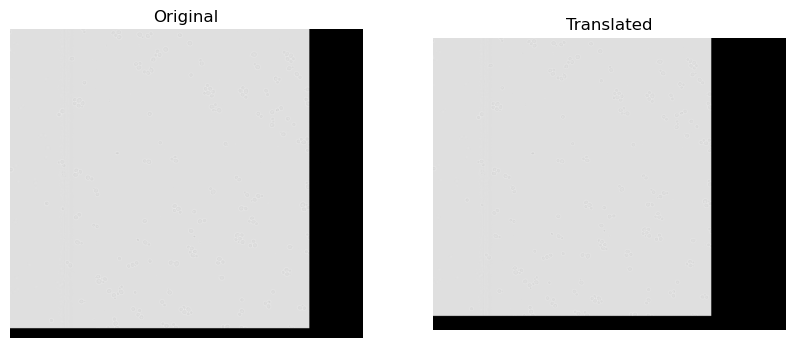

In [53]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0011.tif"
translate_this(image_file=i, at =vector, with_plot=True)

In [54]:
import os
import PIL
import numpy as np
from joblib import Parallel, delayed
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import single_cell_reloc_paraquet.global_functions.global_variables as gv'
from PIL import Image

SyntaxError: EOL while scanning string literal (<ipython-input-54-8da98fcd608c>, line 9)

In [55]:
import os
import PIL
import numpy as np
from joblib import Parallel, delayed
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import single_cell_reloc_paraquet.global_functions.global_variables as gv
from PIL import Image

In [56]:
image_pil = np.array(Image.open(i))

In [57]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=0):
	vect_shape = vector.shape[:2]
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=False):
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)

	# image_trans =

	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext
	cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder
	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_pil, cmap =cmap_val)
		# ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

True

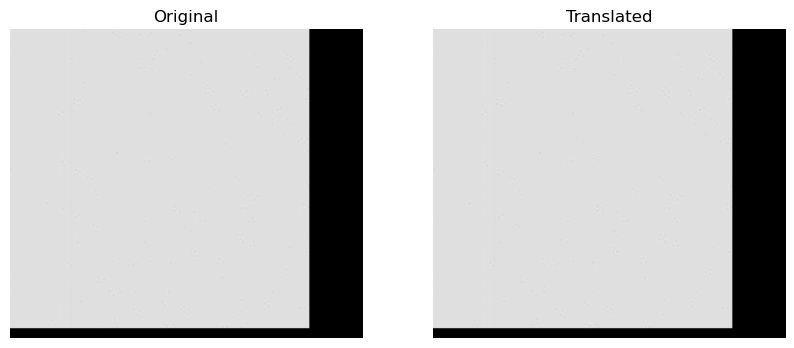

In [58]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0011.tif"
translate_this(image_file=i, at =vector, with_plot=True)

True

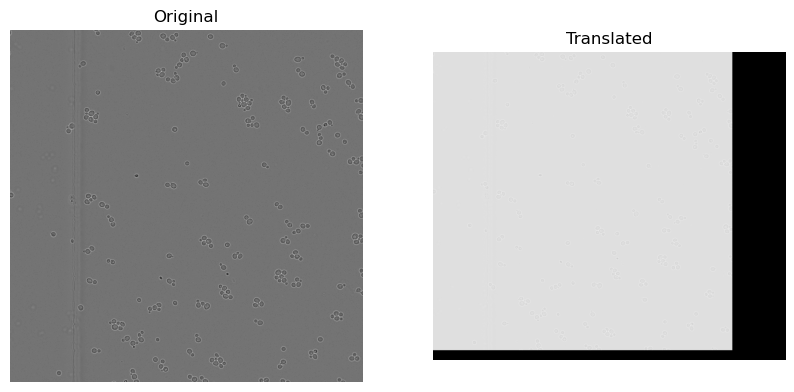

In [59]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0016.tif"
translate_this(image_file=i, at =vector, with_plot=True)

In [60]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=0):
	vect_shape = vector.shape[:2]
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=False):
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB) #* I don't know if this will work for all bit depths
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
		image_trans = image_trans[:-y,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
		image_trans = image_trans[-y:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
		image_trans = image_trans[:,:-x]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
		iamge_trans = image_trans[:,-x:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

True

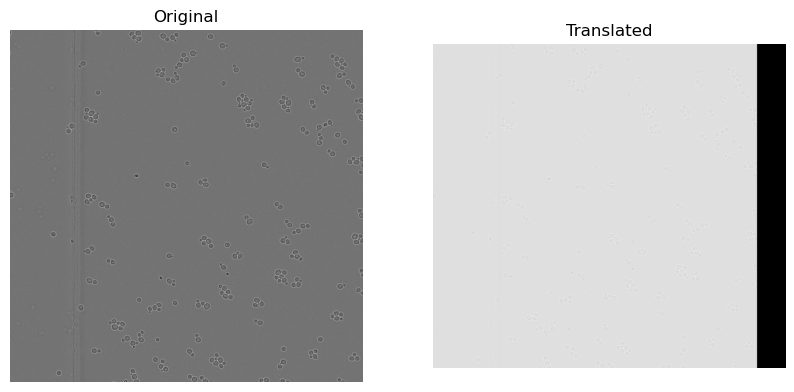

In [61]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0016.tif"
translate_this(image_file=i, at =vector, with_plot=True)

In [62]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=0):
	vect_shape = vector.shape[:2]
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=False):
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB) #* I don't know if this will work for all bit depths
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
		image_trans = image_trans[:,:-y,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
		image_trans = image_trans[:,-y:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
		image_trans = image_trans[:,:,:-x]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
		iamge_trans = image_trans[:,:,-x:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

In [63]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0016.tif"
translate_this(image_file=i, at =vector, with_plot=True)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [64]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=0):
	vect_shape = vector.shape[:2]
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=False):
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB) #* I don't know if this will work for all bit depths
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
		image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
		image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
		image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
		iamge_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

True

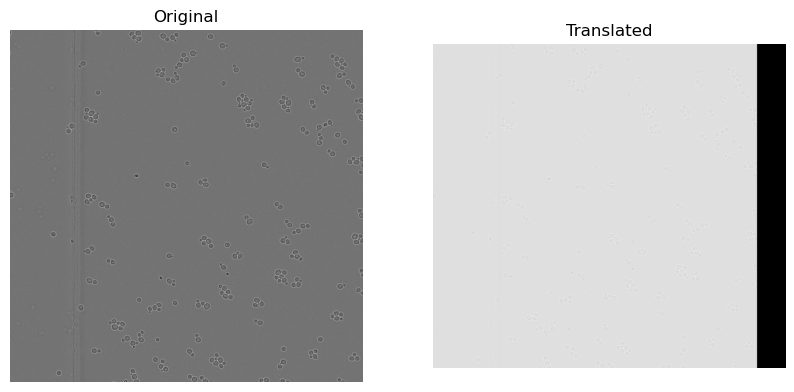

In [65]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0016.tif"
translate_this(image_file=i, at =vector, with_plot=True)

In [66]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=0):
	vect_shape = vector.shape[:2]
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True):
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB) #* I don't know if this will work for all bit depths
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
		image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
		image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
		image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
		iamge_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

True

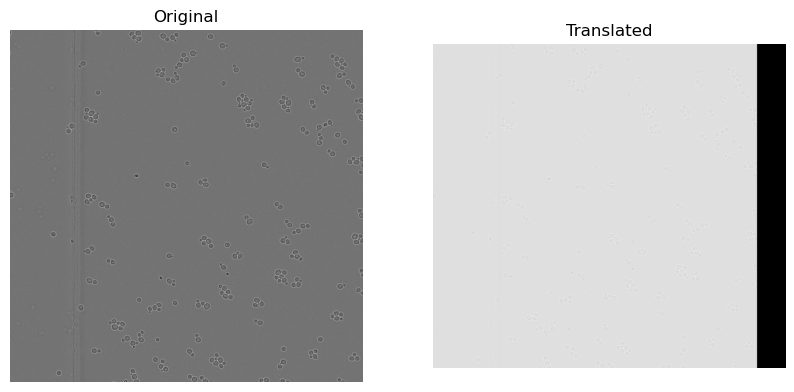

In [67]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0016.tif"
translate_this(image_file=i, at =vector, with_plot=True)

True

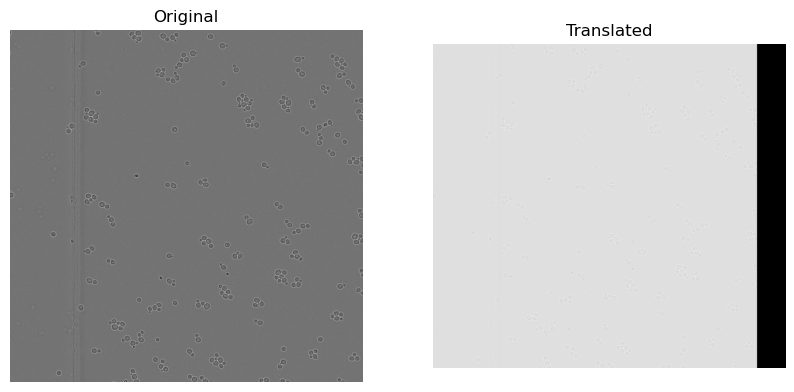

In [68]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0016.tif"
translate_this(image_file=i, at =vector, with_plot=True)


In [69]:
vector

[-183, 37]

In [70]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=0):
	vect_shape = vector.shape[:2]
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True):
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
		# image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
		# image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
		# image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
		# iamge_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

True

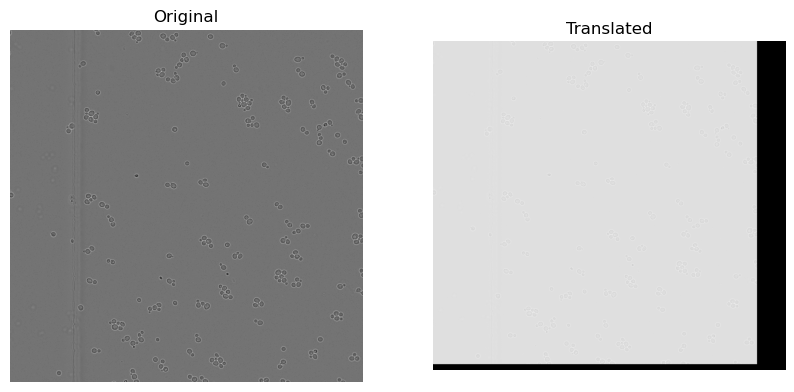

In [71]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0016.tif"
translate_this(image_file=i, at =vector, with_plot=True)


In [72]:
i = image_file

In [73]:
image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH)

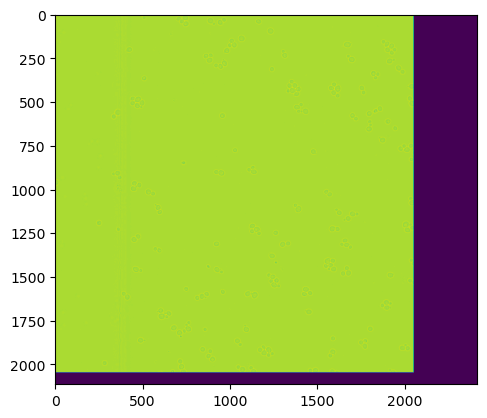

In [74]:
plt.imshow(image_src)

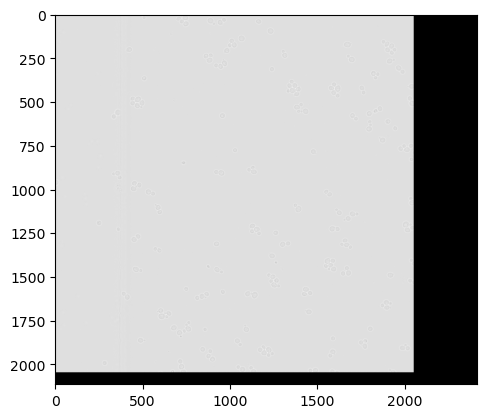

In [75]:
plt.imshow(image_src, cmap = 'gray')

In [76]:
i

'Sub_position090200_time0011.tif'

In [77]:
i = 'Sub_position090200_time0011.tif'

In [78]:
i = 'Sub_position090200_time0020.tif'

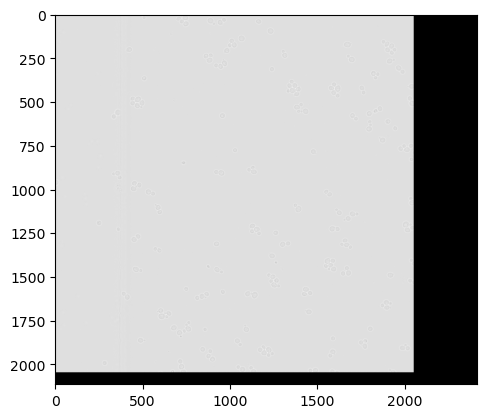

In [79]:
plt.imshow(image_src, cmap = 'gray')

In [80]:
i = image_file

In [81]:
image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH)

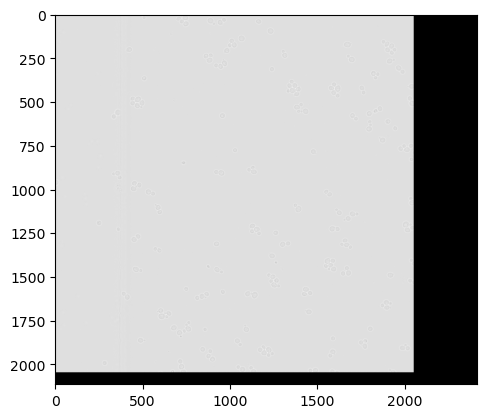

In [82]:
plt.imshow(image_src, cmap = 'gray')

In [83]:
image_file

'Sub_position090200_time0011.tif'

In [84]:
i

'Sub_position090200_time0011.tif'

In [85]:
i = 'Sub_position090200_time0020.tif'

In [86]:
image_file = i

In [87]:
image_file

'Sub_position090200_time0020.tif'

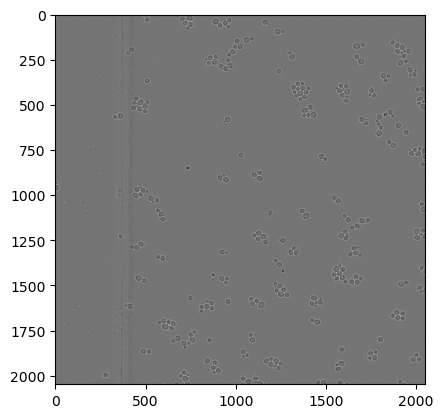

In [88]:
image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH)
plt.imshow(image_src, cmap = 'gray')

In [89]:
left_pad = pad_vector(vector=image_src, how='left', depth=3)

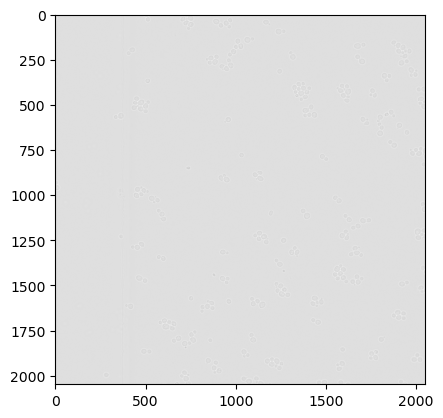

In [90]:
plt.imshow(left_pad, cmap = 'gray')

In [91]:
vector = image_src

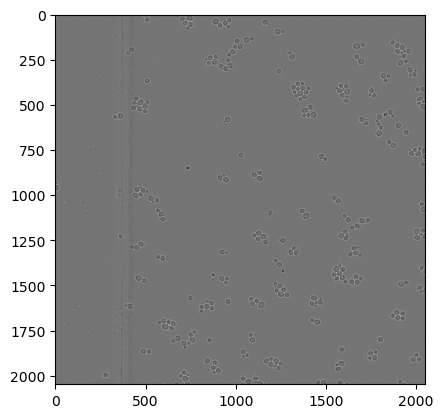

In [92]:
plt.imshow(vector, cmap = 'gray')

In [93]:
vect_shape = vector.shape[:2]

In [94]:
vect_shape

(2048, 2048)

In [95]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=65535):
	vect_shape = vector.shape[:2]
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True):
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
		# image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
		# image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
		# image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
		# iamge_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

In [96]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0020.tif"
translate_this(image_file=i, at =vector, with_plot=True)


False

In [97]:
image_src.shape

(2048, 2048)

In [98]:
image_src.shape[:2]

(2048, 2048)

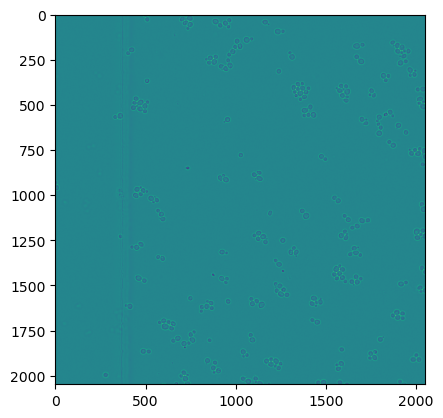

In [99]:
plt.imshow(vector)

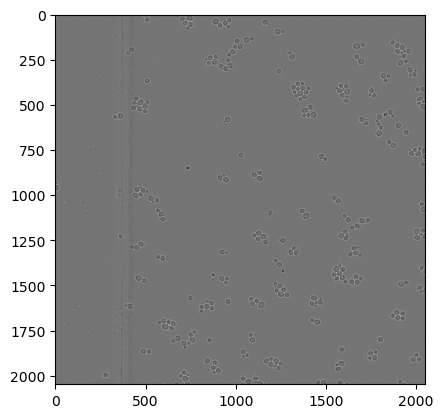

In [100]:
plt.imshow(vector, cmap='gray')

In [101]:
vector.shape[:2]

(2048, 2048)

In [102]:
vector.shape[:1]

(2048,)

In [103]:
vector.shape[:3]

(2048, 2048)

In [104]:
vector.dtype

dtype('uint16')

In [105]:
pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)

NameError: name 'depth' is not defined

In [106]:
pp = np.full(shape=(3, vect_shape[1]), fill_value=constant_value)

NameError: name 'constant_value' is not defined

In [107]:
pp = np.full(shape=(3, vect_shape[1]), fill_value=0)

In [108]:
pp

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [109]:
pp.dtype()

TypeError: 'numpy.dtype[int32]' object is not callable

In [110]:
pp.dtype

dtype('int32')

In [111]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=65535):
	vect_shape = vector.shape[:2]
	type_use = vector.dtype
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value, dtype= type_use)
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value, dtype= type_use)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value,, dtype= type_use)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value, dtype= type_use)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True):
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
		# image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
		# image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
		# image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
		# iamge_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

SyntaxError: invalid syntax (<ipython-input-111-e5d1e8b8f254>, line 15)

In [112]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=65535):
	vect_shape = vector.shape[:2]
	type_use = vector.dtype
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value, dtype= type_use)
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value, dtype= type_use)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value, dtype= type_use)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value, dtype= type_use)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True):
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
		# image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
		# image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
		# image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
		# iamge_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

In [113]:
pp = np.full(shape=(vect_shape[0], 3), fill_value=0, dtype= type_use)

NameError: name 'type_use' is not defined

In [114]:
type_use = vector.dtype

In [115]:
pp = np.full(shape=(vect_shape[0], 3), fill_value=0, dtype= type_use)

In [116]:
pp.dtype

dtype('uint16')

In [117]:
vector.dtype

dtype('uint16')

In [118]:
pv = np.vstack(tup=(pp, vector))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 2048

In [119]:
pv = np.hstack(tup=(pp, vector))

In [120]:
pv.dtype

dtype('uint16')

In [121]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=65535):
	vect_shape = vector.shape[:2]
	type_use = vector.dtype #* Added for variable bit depth
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value, dtype= type_use) #* Modified for variable bit depth
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value, dtype= type_use)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value, dtype= type_use)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value, dtype= type_use)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True):
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
		# image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
		# image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
		# image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
		# iamge_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

In [122]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0020.tif"
translate_this(image_file=i, at =vector, with_plot=True)

False

In [123]:
vetor = [36, -185]

In [124]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0020.tif"
translate_this(image_file=i, at =vector, with_plot=True)

False

In [125]:
vector

array([[32683, 32924, 32816, ..., 32844, 32619, 32836],
       [32762, 32737, 32841, ..., 32705, 32590, 32636],
       [32784, 32463, 32632, ..., 32902, 32502, 32774],
       ...,
       [32769, 32588, 32733, ..., 32886, 32751, 32793],
       [32612, 32781, 32825, ..., 32423, 32805, 33065],
       [32718, 32882, 32571, ..., 32763, 32609, 33079]], dtype=uint16)

In [126]:
vector = [36, -185]

True

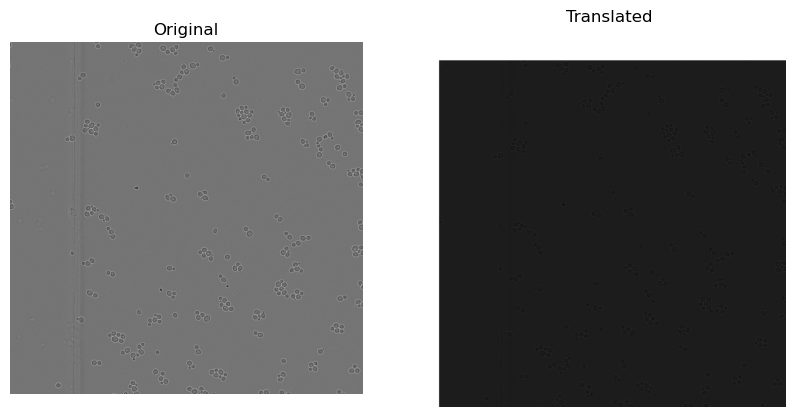

In [127]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0020.tif"
translate_this(image_file=i, at =vector, with_plot=True)

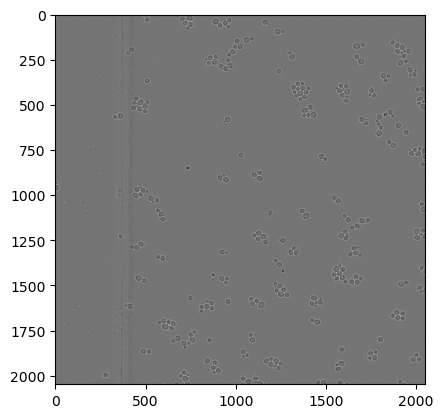

In [128]:
plt.imshow(image_src, cmap='gray')

In [129]:
at

NameError: name 'at' is not defined

In [130]:
image_trans = shift_image(image_src=image_src, at=at)

NameError: name 'at' is not defined

In [131]:
image_trans = shift_image(image_src=image_src, at=vector)

In [132]:
plt.imshow(image_trans, cmap=cmap_val)

NameError: name 'cmap_val' is not defined

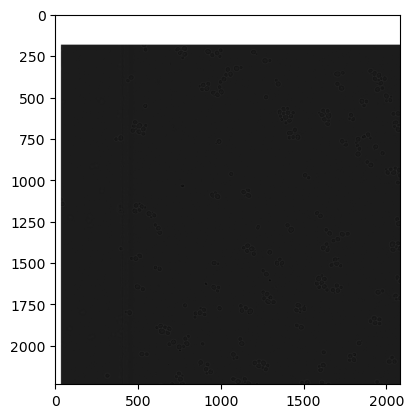

In [133]:
plt.imshow(image_trans, cmap='gray')

In [134]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=0):
	vect_shape = vector.shape[:2]
	type_use = vector.dtype #* Added for variable bit depth
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value, dtype= type_use) #* Modified for variable bit depth
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value, dtype= type_use)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value, dtype= type_use)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value, dtype= type_use)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True): #? This is fine
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
		# image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
		# image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_)
		image_trans = shifter(vect=left_pad, y=y, y_=y_)
		# image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_)
		image_trans = shifter(vect=right_pad, y=y, y_=y_)
		# iamge_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

In [135]:
vector

[36, -185]

True

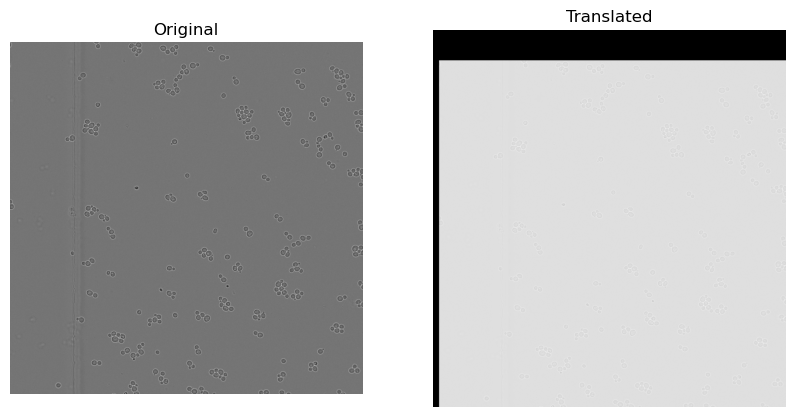

In [136]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0020.tif"
translate_this(image_file=i, at =vector, with_plot=True)

In [137]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, fill_value):
	vect_shape = vector.shape[:2]
	type_use = vector.dtype #* Added for variable bit depth
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=fill_value, dtype= type_use) #* Modified for variable bit depth
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=fill_value, dtype= type_use)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=fill_value, dtype= type_use)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=fill_value, dtype= type_use)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True): #? This is fine
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_)
		# image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_)
		# image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	fill_value = np.mean(image_src)
	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_, fill_value=fill_value)
		image_trans = shifter(vect=left_pad, y=y, y_=y_, fill_value = fill_value)
		# image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_, fill_value = fill_value)
		image_trans = shifter(vect=right_pad, y=y, y_=y_, fill_value = fill_value)
		# iamge_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

In [138]:
translate_this(image_file=i, at =vector, with_plot=True)

TypeError: shifter() got an unexpected keyword argument 'fill_value'

In [139]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, fill_value):
	vect_shape = vector.shape[:2]
	type_use = vector.dtype #* Added for variable bit depth
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=fill_value, dtype= type_use) #* Modified for variable bit depth
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=fill_value, dtype= type_use)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=fill_value, dtype= type_use)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=fill_value, dtype= type_use)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True): #? This is fine
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_, fill_value):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_, fill_value =fill_value)
		# image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_, fill_value= fill_value)
		# image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	fill_value = np.mean(image_src)
	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_, fill_value=fill_value)
		image_trans = shifter(vect=left_pad, y=y, y_=y_, fill_value = fill_value)
		# image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_, fill_value = fill_value)
		image_trans = shifter(vect=right_pad, y=y, y_=y_, fill_value = fill_value)
		# iamge_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

True

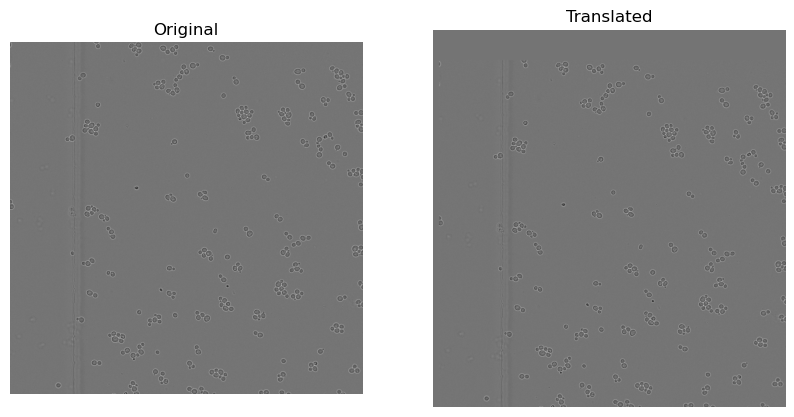

In [140]:
translate_this(image_file=i, at =vector, with_plot=True)

In [141]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, fill_value):
	vect_shape = vector.shape[:2]
	type_use = vector.dtype #* Added for variable bit depth
	temp_value = 50
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=temp_value, dtype= type_use) #* Modified for variable bit depth
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=temp_value, dtype= type_use)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=temp_value, dtype= type_use)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=temp_value, dtype= type_use)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True): #? This is fine
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_, fill_value):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_, fill_value =fill_value)
		# image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_, fill_value= fill_value)
		# image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	fill_value = np.mean(image_src)
	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_, fill_value=fill_value)
		image_trans = shifter(vect=left_pad, y=y, y_=y_, fill_value = fill_value)
		# image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_, fill_value = fill_value)
		image_trans = shifter(vect=right_pad, y=y, y_=y_, fill_value = fill_value)
		# iamge_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

True

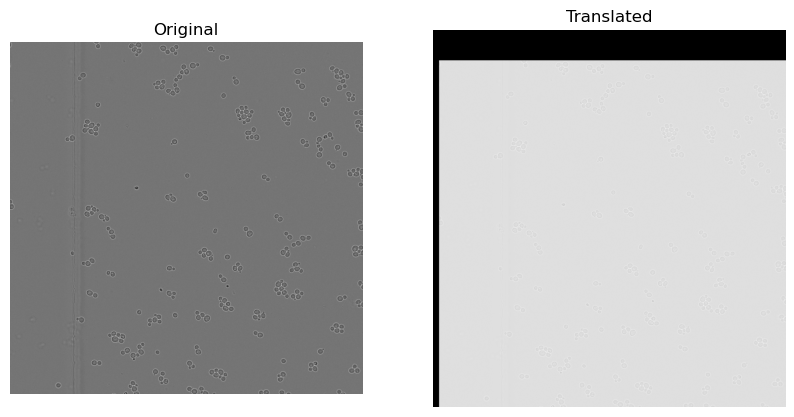

In [142]:
translate_this(image_file=i, at =vector, with_plot=True)

In [143]:
vector

[36, -185]

In [144]:
vector = [-185,-36]

True

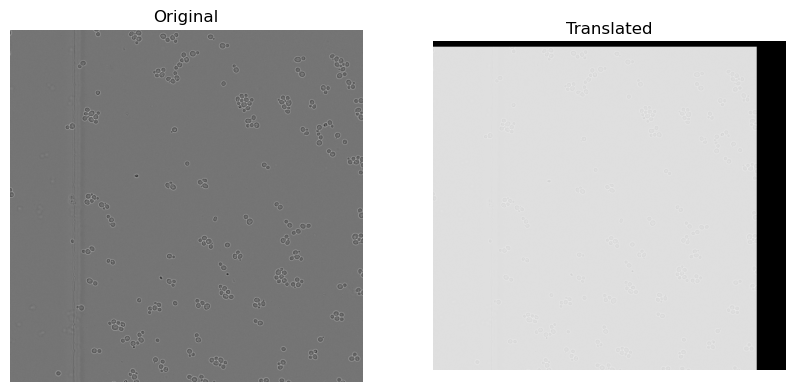

In [145]:
translate_this(image_file=i, at =vector, with_plot=True)

In [146]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, fill_value):
	vect_shape = vector.shape[:2]
	type_use = vector.dtype #* Added for variable bit depth
	temp_value = 50
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=temp_value, dtype= type_use) #* Modified for variable bit depth
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=temp_value, dtype= type_use)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=temp_value, dtype= type_use)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=temp_value, dtype= type_use)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True): #? This is fine
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_, fill_value):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_, fill_value =fill_value)
		# image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_, fill_value= fill_value)
		# image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	fill_value = np.mean(image_src)
	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_, fill_value=fill_value)
		image_trans = shifter(vect=left_pad, y=y, y_=y_, fill_value = fill_value)
		image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_, fill_value = fill_value)
		image_trans = shifter(vect=right_pad, y=y, y_=y_, fill_value = fill_value)
		image_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

True

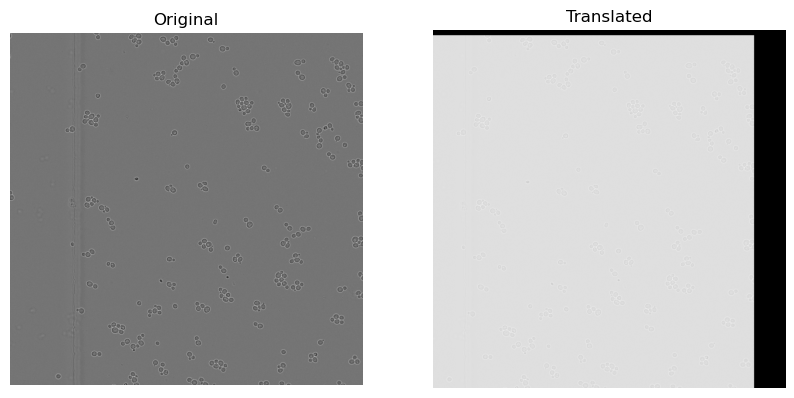

In [147]:
translate_this(image_file=i, at =vector, with_plot=True)

In [148]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, fill_value):
	vect_shape = vector.shape[:2]
	type_use = vector.dtype #* Added for variable bit depth
	temp_value = 50
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=temp_value, dtype= type_use) #* Modified for variable bit depth
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=temp_value, dtype= type_use)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=temp_value, dtype= type_use)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=temp_value, dtype= type_use)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True): #? This is fine
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_, fill_value):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_, fill_value =fill_value)
		image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_, fill_value= fill_value)
		image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	fill_value = np.mean(image_src)
	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_, fill_value=fill_value)
		image_trans = shifter(vect=left_pad, y=y, y_=y_, fill_value = fill_value)
		image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_, fill_value = fill_value)
		image_trans = shifter(vect=right_pad, y=y, y_=y_, fill_value = fill_value)
		image_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

True

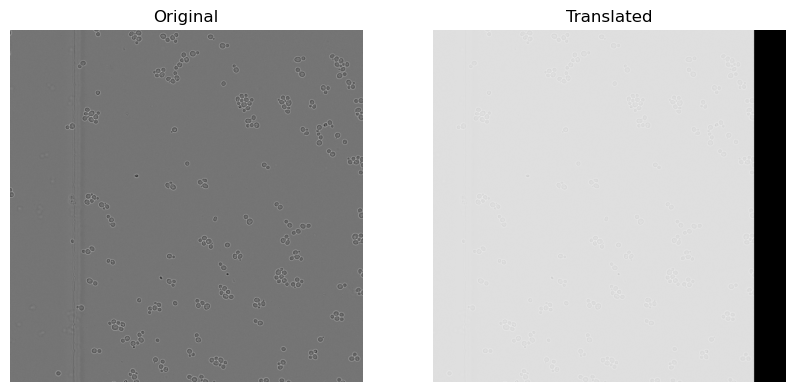

In [149]:
translate_this(image_file=i, at =vector, with_plot=True)

In [150]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, fill_value):
	vect_shape = vector.shape[:2]
	type_use = vector.dtype #* Added for variable bit depth
	temp_value = 50
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=temp_value, dtype= type_use) #* Modified for variable bit depth
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=temp_value, dtype= type_use)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=temp_value, dtype= type_use)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=temp_value, dtype= type_use)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True): #? This is fine
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_, fill_value):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_, fill_value =fill_value)
		image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_, fill_value= fill_value)
		image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	fill_value = np.mean(image_src)
	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_, fill_value=fill_value)
		image_trans = shifter(vect=left_pad, y=y, y_=y_, fill_value = fill_value)
		image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_, fill_value = fill_value)
		image_trans = shifter(vect=right_pad, y=y, y_=y_, fill_value = fill_value)
		image_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

In [151]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, fill_value):
	vect_shape = vector.shape[:2]
	type_use = vector.dtype #* Added for variable bit depth
	temp_value = 50
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=temp_value, dtype= type_use) #* Modified for variable bit depth
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=temp_value, dtype= type_use)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=temp_value, dtype= type_use)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=temp_value, dtype= type_use)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True): #? This is fine
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_, fill_value):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_, fill_value =fill_value)
		image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_, fill_value= fill_value)
		image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	fill_value = np.mean(image_src)
	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_, fill_value=fill_value)
		image_trans = shifter(vect=left_pad, y=y, y_=y_, fill_value = fill_value)
		image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_, fill_value = fill_value)
		image_trans = shifter(vect=right_pad, y=y, y_=y_, fill_value = fill_value)
		image_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

True

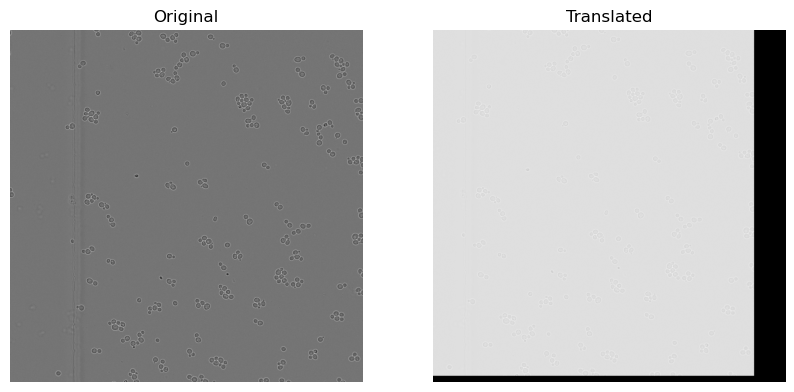

In [152]:
translate_this(image_file=i, at =vector, with_plot=True)

In [153]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, fill_value):
	vect_shape = vector.shape[:2]
	type_use = vector.dtype #* Added for variable bit depth
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=fill_value, dtype= type_use) #* Modified for variable bit depth
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=fill_value, dtype= type_use)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=fill_value, dtype= type_use)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=fill_value, dtype= type_use)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True): #? This is fine
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_, fill_value):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_, fill_value =fill_value)
		image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_, fill_value= fill_value)
		image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	fill_value = np.mean(image_src)
	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_, fill_value=fill_value)
		image_trans = shifter(vect=left_pad, y=y, y_=y_, fill_value = fill_value)
		image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_, fill_value = fill_value)
		image_trans = shifter(vect=right_pad, y=y, y_=y_, fill_value = fill_value)
		image_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	#// cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

True

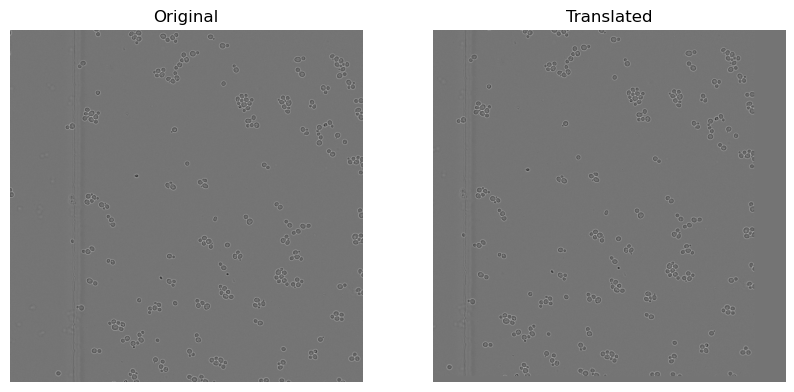

In [154]:
translate_this(image_file=i, at =vector, with_plot=True)

In [155]:
os.getcwd()

"C:\\Users\\pcnba\\Grant Brown's Lab Dropbox\\Peter Bartlett\\Peter Bartlett Data\\Testing_shift_fix\\Images"

In [156]:
miniImgIndex

<function __main__.miniImgIndex()>

In [157]:
miniImgIndex()

InvalidIndexError: (slice(None, None, None), 0)

In [159]:
def miniImgIndex():
	def f_Frame_int(z):
		start = z.find('_time')+5
		end = z.find('_time')+9
		return(int(z[start:end])) #* This is a modification of normal string returned version
	def get_file_name(x):
		os.path.join(x)
		return(name)

	count = 0
	mini_imgIndex = []
	for root, dirs, files in os.walk(os.getcwd()):
		for name in files:
			if name.endswith(".tif"):
				mini_imgIndex.append({'File_name': os.path.join(name)})
				count = count + 1
				print(count, end="/r")
			else :
				pass
	del dirs
	del root

	mini_imgIndex = pd.DataFrame(mini_imgIndex)
	mini_imgIndex['Frame'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_Frame_int)
	# mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lam) #. Change this line
	# mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lambda x: os.path.basename(x).split('/')[-1])

	return(mini_imgIndex)

In [160]:
miniImgIndex

<function __main__.miniImgIndex()>

In [161]:
miniImgIndex()

File_name  Frame
0       Sub_position090200_time0011.tif     11
1   Sub_position090200_time0011test.tif     11
2       Sub_position090200_time0012.tif     12
3       Sub_position090200_time0013.tif     13
4       Sub_position090200_time0014.tif     14
5       Sub_position090200_time0015.tif     15
6       Sub_position090200_time0016.tif     16
7   Sub_position090200_time0016test.tif     16
8       Sub_position090200_time0017.tif     17
9       Sub_position090200_time0018.tif     18
10      Sub_position090200_time0019.tif     19
11      Sub_position090200_time0020.tif     20
12      Sub_position090200_time0021.tif     21
13      Sub_position090200_time0022.tif     22
14      Sub_position090200_time0023.tif     23
15      Sub_position090200_time0024.tif     24
16      Sub_position090200_time0025.tif     25
17      Sub_position090200_time0026.tif     26
18      Sub_position090200_time0027.tif     27
19      Sub_position090200_time0028.tif     28
20      Sub_position090200_time0029.tif     29
21      Sub_position090200_time0030.tif     30
22      Sub_position090200_time0031.tif     31
23      Sub_position090200_time0032.tif     32
24      Sub_position090200_time0033.tif     33
25      Sub_position090200_time0034.tif     34
26      Sub_position090200_time0035.tif     35
27      Sub_position090200_time0036.tif     36
28      Sub_position090200_time0037.tif     37
29      Sub_position090200_time0038.tif     38
30      Sub_position090200_time0039.tif     39
31      Sub_position090200_time0040.tif     40
32      Sub_position090200_time0041.tif     41
33      Sub_position090200_time0042.tif     42
34      Sub_position090200_time0043.tif     43
35      Sub_position090200_time0044.tif     44
36      Sub_position090200_time0045.tif     45
37      Sub_position090200_time0046.tif     46
38      Sub_position090200_time0047.tif     47
39      Sub_position090200_time0048.tif     48
40      Sub_position090200_time0049.tif     49
41      Sub_position090200_time0050.tif     50
42      Sub_position090200_time0051.tif     51
43      Sub_position090200_time0052.tif     52
44      Sub_position090200_time0053.tif     53
45      Sub_position090200_time0054.tif     54
46      Sub_position090200_time0055.tif     55
47      Sub_position090200_time0056.tif     56
48      Sub_position090200_time0057.tif     57

In [162]:
x = "test"

In [163]:
def miniImgIndex():
	def f_Frame_int(z):
		start = z.find('_time')+5
		end = z.find('_time')+9
		return(int(z[start:end])) #* This is a modification of normal string returned version
	def get_file_name(x):
		os.path.join(x)
		return(name)
	def f_skip_test(x):
		if "test" in x:
			return(None)
		else:
			return(x)

	count = 0
	mini_imgIndex = []
	for root, dirs, files in os.walk(os.getcwd()):
		for name in files:
			if name.endswith(".tif"):
				mini_imgIndex.append({'File_name': os.path.join(name)})
				count = count + 1
				print(count, end="/r")
			else :
				pass
	del dirs
	del root

	mini_imgIndex = pd.DataFrame(mini_imgIndex)
	mini_imgIndex['Frame'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_Frame_int)
	mini_imgIndex['File_name'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_skip_test)
	# mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lam) #. Change this line
	# mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lambda x: os.path.basename(x).split('/')[-1])

	return(mini_imgIndex)
mini_imgIndex

Path  Frame
0   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     11
1   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     12
2   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     13
3   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     14
4   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     15
5   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     16
6   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     17
7   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     18
8   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     19
9   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     20
10  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     21
11  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     22
12  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     23
13  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     24
14  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     25
15  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     26
16  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     27
17  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     28
18  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     29
19  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     30
20  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     31
21  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     32
22  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     33
23  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     34
24  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     35
25  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     36
26  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     37
27  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     38
28  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     39
29  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     40
30  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     41
31  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     42
32  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     43
33  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     44
34  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     45
35  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     46
36  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     47
37  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     48
38  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     49
39  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     50
40  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     51
41  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     52
42  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     53
43  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     54
44  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     55
45  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     56
46  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     57

In [164]:
def miniImgIndex():
	def f_Frame_int(z):
		start = z.find('_time')+5
		end = z.find('_time')+9
		return(int(z[start:end])) #* This is a modification of normal string returned version
	def get_file_name(x):
		os.path.join(x)
		return(name)
	def f_skip_test(x):
		if "test" in x:
			return(None)
		else:
			return(x)

	count = 0
	mini_imgIndex = []
	for root, dirs, files in os.walk(os.getcwd()):
		for name in files:
			if name.endswith(".tif"):
				mini_imgIndex.append({'File_name': os.path.join(name)})
				count = count + 1
				print(count, end="/r")
			else :
				pass
	del dirs
	del root

	mini_imgIndex = pd.DataFrame(mini_imgIndex)
	mini_imgIndex['Frame'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_Frame_int)
	mini_imgIndex['File_name'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_skip_test)
	# mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lam) #. Change this line
	# mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lambda x: os.path.basename(x).split('/')[-1])

	return(mini_imgIndex)
mini_imgIndex

Path  Frame
0   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     11
1   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     12
2   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     13
3   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     14
4   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     15
5   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     16
6   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     17
7   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     18
8   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     19
9   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     20
10  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     21
11  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     22
12  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     23
13  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     24
14  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     25
15  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     26
16  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     27
17  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     28
18  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     29
19  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     30
20  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     31
21  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     32
22  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     33
23  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     34
24  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     35
25  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     36
26  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     37
27  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     38
28  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     39
29  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     40
30  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     41
31  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     42
32  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     43
33  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     44
34  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     45
35  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     46
36  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     47
37  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     48
38  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     49
39  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     50
40  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     51
41  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     52
42  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     53
43  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     54
44  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     55
45  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     56
46  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...     57

In [165]:
def miniImgIndex():
	def f_Frame_int(z):
		start = z.find('_time')+5
		end = z.find('_time')+9
		return(int(z[start:end])) #* This is a modification of normal string returned version
	def get_file_name(x):
		os.path.join(x)
		return(name)
	def f_skip_test(x):
		if "test" in x:
			return(None)
		else:
			return(x)

	count = 0
	mini_imgIndex = []
	for root, dirs, files in os.walk(os.getcwd()):
		for name in files:
			if name.endswith(".tif"):
				mini_imgIndex.append({'File_name': os.path.join(name)})
				count = count + 1
				print(count, end="/r")
			else :
				pass
	del dirs
	del root

	mini_imgIndex = pd.DataFrame(mini_imgIndex)
	mini_imgIndex['Frame'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_Frame_int)
	mini_imgIndex['File_name'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_skip_test)
	# mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lam) #. Change this line
	# mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lambda x: os.path.basename(x).split('/')[-1])

	return(mini_imgIndex)
mini_imgIndex = miniImgIndex

In [166]:
def miniImgIndex():
	def f_Frame_int(z):
		start = z.find('_time')+5
		end = z.find('_time')+9
		return(int(z[start:end])) #* This is a modification of normal string returned version
	def get_file_name(x):
		os.path.join(x)
		return(name)
	def f_skip_test(x):
		if "test" in x:
			return(None)
		else:
			return(x)

	count = 0
	mini_imgIndex = []
	for root, dirs, files in os.walk(os.getcwd()):
		for name in files:
			if name.endswith(".tif"):
				mini_imgIndex.append({'File_name': os.path.join(name)})
				count = count + 1
				print(count, end="/r")
			else :
				pass
	del dirs
	del root

	mini_imgIndex = pd.DataFrame(mini_imgIndex)
	mini_imgIndex['Frame'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_Frame_int)
	mini_imgIndex['File_name'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_skip_test)
	# mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lam) #. Change this line
	# mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lambda x: os.path.basename(x).split('/')[-1])

	return(mini_imgIndex)
mini_imgIndex = miniImgIndex
mini_imgIndex

<function __main__.miniImgIndex()>

In [167]:
def miniImgIndex():
	def f_Frame_int(z):
		start = z.find('_time')+5
		end = z.find('_time')+9
		return(int(z[start:end])) #* This is a modification of normal string returned version
	def get_file_name(x):
		os.path.join(x)
		return(name)
	def f_skip_test(x):
		if "test" in x:
			return(None)
		else:
			return(x)

	count = 0
	mini_imgIndex = []
	for root, dirs, files in os.walk(os.getcwd()):
		for name in files:
			if name.endswith(".tif"):
				mini_imgIndex.append({'File_name': os.path.join(name)})
				count = count + 1
				print(count, end="/r")
			else :
				pass
	del dirs
	del root

	mini_imgIndex = pd.DataFrame(mini_imgIndex)
	mini_imgIndex['Frame'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_Frame_int)
	mini_imgIndex['File_name'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_skip_test)
	# mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lam) #. Change this line
	# mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lambda x: os.path.basename(x).split('/')[-1])

	return(mini_imgIndex)
mini_imgIndex = miniImgIndex()
mini_imgIndex

File_name  Frame
0   Sub_position090200_time0011.tif     11
1                              None     11
2   Sub_position090200_time0012.tif     12
3   Sub_position090200_time0013.tif     13
4   Sub_position090200_time0014.tif     14
5   Sub_position090200_time0015.tif     15
6   Sub_position090200_time0016.tif     16
7                              None     16
8   Sub_position090200_time0017.tif     17
9   Sub_position090200_time0018.tif     18
10  Sub_position090200_time0019.tif     19
11  Sub_position090200_time0020.tif     20
12  Sub_position090200_time0021.tif     21
13  Sub_position090200_time0022.tif     22
14  Sub_position090200_time0023.tif     23
15  Sub_position090200_time0024.tif     24
16  Sub_position090200_time0025.tif     25
17  Sub_position090200_time0026.tif     26
18  Sub_position090200_time0027.tif     27
19  Sub_position090200_time0028.tif     28
20  Sub_position090200_time0029.tif     29
21  Sub_position090200_time0030.tif     30
22  Sub_position090200_time0031.tif     31
23  Sub_position090200_time0032.tif     32
24  Sub_position090200_time0033.tif     33
25  Sub_position090200_time0034.tif     34
26  Sub_position090200_time0035.tif     35
27  Sub_position090200_time0036.tif     36
28  Sub_position090200_time0037.tif     37
29  Sub_position090200_time0038.tif     38
30  Sub_position090200_time0039.tif     39
31  Sub_position090200_time0040.tif     40
32  Sub_position090200_time0041.tif     41
33  Sub_position090200_time0042.tif     42
34  Sub_position090200_time0043.tif     43
35  Sub_position090200_time0044.tif     44
36  Sub_position090200_time0045.tif     45
37  Sub_position090200_time0046.tif     46
38  Sub_position090200_time0047.tif     47
39  Sub_position090200_time0048.tif     48
40  Sub_position090200_time0049.tif     49
41  Sub_position090200_time0050.tif     50
42  Sub_position090200_time0051.tif     51
43  Sub_position090200_time0052.tif     52
44  Sub_position090200_time0053.tif     53
45  Sub_position090200_time0054.tif     54
46  Sub_position090200_time0055.tif     55
47  Sub_position090200_time0056.tif     56
48  Sub_position090200_time0057.tif     57

In [168]:
def miniImgIndex():
	def f_Frame_int(z):
		start = z.find('_time')+5
		end = z.find('_time')+9
		return(int(z[start:end])) #* This is a modification of normal string returned version
	def get_file_name(x):
		os.path.join(x)
		return(name)
	def f_skip_test(x):
		if "test" in x:
			return(None)
		else:
			return(x)

	count = 0
	mini_imgIndex = []
	for root, dirs, files in os.walk(os.getcwd()):
		for name in files:
			if name.endswith(".tif"):
				mini_imgIndex.append({'File_name': os.path.join(name)})
				count = count + 1
				print(count, end="/r")
			else :
				pass
	del dirs
	del root

	mini_imgIndex = pd.DataFrame(mini_imgIndex)
	mini_imgIndex['Frame'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_Frame_int) #* Skip where the file was a test to avoid recursive testing
	mini_imgIndex['File_name'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_skip_test)
	mini_imgIndex.drop_na(inplace = True)
	# mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lam) #. Change this line
	# mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lambda x: os.path.basename(x).split('/')[-1])

	return(mini_imgIndex)

mini_imgIndex = miniImgIndex()
mini_imgIndex

AttributeError: 'DataFrame' object has no attribute 'drop_na'

In [169]:
def miniImgIndex():
	def f_Frame_int(z):
		start = z.find('_time')+5
		end = z.find('_time')+9
		return(int(z[start:end])) #* This is a modification of normal string returned version
	def get_file_name(x):
		os.path.join(x)
		return(name)
	def f_skip_test(x):
		if "test" in x:
			return(None)
		else:
			return(x)

	count = 0
	mini_imgIndex = []
	for root, dirs, files in os.walk(os.getcwd()):
		for name in files:
			if name.endswith(".tif"):
				mini_imgIndex.append({'File_name': os.path.join(name)})
				count = count + 1
				print(count, end="/r")
			else :
				pass
	del dirs
	del root

	mini_imgIndex = pd.DataFrame(mini_imgIndex)
	mini_imgIndex['Frame'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_Frame_int) #* Skip where the file was a test to avoid recursive testing
	mini_imgIndex['File_name'] = pd.Series(mini_imgIndex.iloc[:,0]).apply(f_skip_test)
	mini_imgIndex.dropna(inplace=True)
	# mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lam) #. Change this line
	# mini_imgIndex['File_name'] = pd.Series(mini_imgIndex[:,0]).apply(lambda x: os.path.basename(x).split('/')[-1])

	return(mini_imgIndex)

mini_imgIndex = miniImgIndex()
mini_imgIndex

File_name  Frame
0   Sub_position090200_time0011.tif     11
2   Sub_position090200_time0012.tif     12
3   Sub_position090200_time0013.tif     13
4   Sub_position090200_time0014.tif     14
5   Sub_position090200_time0015.tif     15
6   Sub_position090200_time0016.tif     16
8   Sub_position090200_time0017.tif     17
9   Sub_position090200_time0018.tif     18
10  Sub_position090200_time0019.tif     19
11  Sub_position090200_time0020.tif     20
12  Sub_position090200_time0021.tif     21
13  Sub_position090200_time0022.tif     22
14  Sub_position090200_time0023.tif     23
15  Sub_position090200_time0024.tif     24
16  Sub_position090200_time0025.tif     25
17  Sub_position090200_time0026.tif     26
18  Sub_position090200_time0027.tif     27
19  Sub_position090200_time0028.tif     28
20  Sub_position090200_time0029.tif     29
21  Sub_position090200_time0030.tif     30
22  Sub_position090200_time0031.tif     31
23  Sub_position090200_time0032.tif     32
24  Sub_position090200_time0033.tif     33
25  Sub_position090200_time0034.tif     34
26  Sub_position090200_time0035.tif     35
27  Sub_position090200_time0036.tif     36
28  Sub_position090200_time0037.tif     37
29  Sub_position090200_time0038.tif     38
30  Sub_position090200_time0039.tif     39
31  Sub_position090200_time0040.tif     40
32  Sub_position090200_time0041.tif     41
33  Sub_position090200_time0042.tif     42
34  Sub_position090200_time0043.tif     43
35  Sub_position090200_time0044.tif     44
36  Sub_position090200_time0045.tif     45
37  Sub_position090200_time0046.tif     46
38  Sub_position090200_time0047.tif     47
39  Sub_position090200_time0048.tif     48
40  Sub_position090200_time0049.tif     49
41  Sub_position090200_time0050.tif     50
42  Sub_position090200_time0051.tif     51
43  Sub_position090200_time0052.tif     52
44  Sub_position090200_time0053.tif     53
45  Sub_position090200_time0054.tif     54
46  Sub_position090200_time0055.tif     55
47  Sub_position090200_time0056.tif     56
48  Sub_position090200_time0057.tif     57

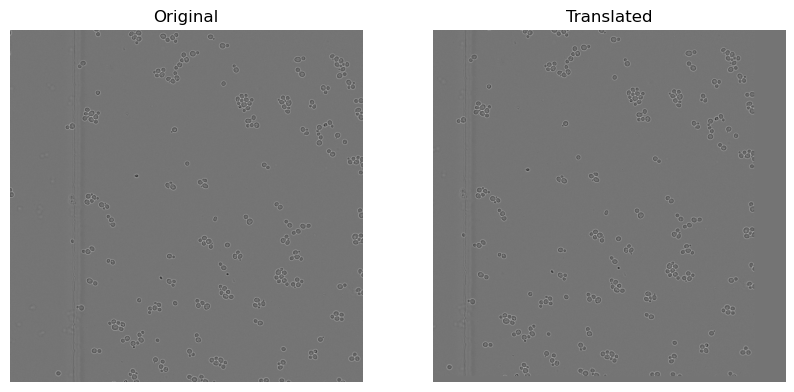

In [170]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0020.tif"
vector = [-185, -36]
translate_this(image_file=i, at =vector, with_plot=True)

if __name__ == "__main__":
	vector = input('What are the vector aspects {x, y}').split(sep= ", ")
	vector[0] = int(vector[0])
	vector[1] = int(vector[1])
	stop = int(input("What is the max frame to be shift"))
	folder = input("Where is the directory to be done?")
	folder = gv.slash_switch(folder)
	parallel_state = input("Should the files be shifted in parallel? [y/n]")
	if parallel_state == "y" or parallel_state == "yes" or parallel_state =="Y" or parallel_state == "Yes" or parallel_state == "YES":
		parallel_state = True
	else:
		parallel_state = False
	os.chdir(folder)
	use_cores_len = os.cpu_count()
	mini_imgIndex = miniImgIndex() #* Run search in current folder
	miniImgIndex_subset = mini_imgIndex.loc[mini_imgIndex['Frame']>= stop]

	if parallel_state:
		Parallel(n_jobs=use_cores_len, verbose = 100, prefer='threads')(delayed(translate_this)(image_file = i, at = vector, with_plot=False, gray_scale=True) for i in mini_imgIndex['File_name']) #* This should prefer threads as it largely IO limited.
	else:
		for i in mini_imgIndex['File_name']:
			translate_this(image_file= i, at = vector, with_plot=False, gray_scale=True )

In [171]:
vector

[-185, -136]

In [172]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, fill_value):
	vect_shape = vector.shape[:2]
	type_use = vector.dtype #* Added for variable bit depth
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=fill_value, dtype= type_use) #* Modified for variable bit depth
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=fill_value, dtype= type_use)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=fill_value, dtype= type_use)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=fill_value, dtype= type_use)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True): #? This is fine
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_, fill_value):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_, fill_value =fill_value)
		image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_, fill_value= fill_value)
		image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	fill_value = np.mean(image_src)
	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_, fill_value=fill_value)
		image_trans = shifter(vect=left_pad, y=y, y_=y_, fill_value = fill_value)
		image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_, fill_value = fill_value)
		image_trans = shifter(vect=right_pad, y=y, y_=y_, fill_value = fill_value)
		image_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "test" + image_ext

	cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

In [173]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, fill_value):
	vect_shape = vector.shape[:2]
	type_use = vector.dtype #* Added for variable bit depth
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=fill_value, dtype= type_use) #* Modified for variable bit depth
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=fill_value, dtype= type_use)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=fill_value, dtype= type_use)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=fill_value, dtype= type_use)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True): #? This is fine
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_, fill_value):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_, fill_value =fill_value)
		image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_, fill_value= fill_value)
		image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	fill_value = np.mean(image_src)
	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_, fill_value=fill_value)
		image_trans = shifter(vect=left_pad, y=y, y_=y_, fill_value = fill_value)
		image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_, fill_value = fill_value)
		image_trans = shifter(vect=right_pad, y=y, y_=y_, fill_value = fill_value)
		image_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "_test" + image_ext

	cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

ValueError: invalid literal for int() with base 10: ''

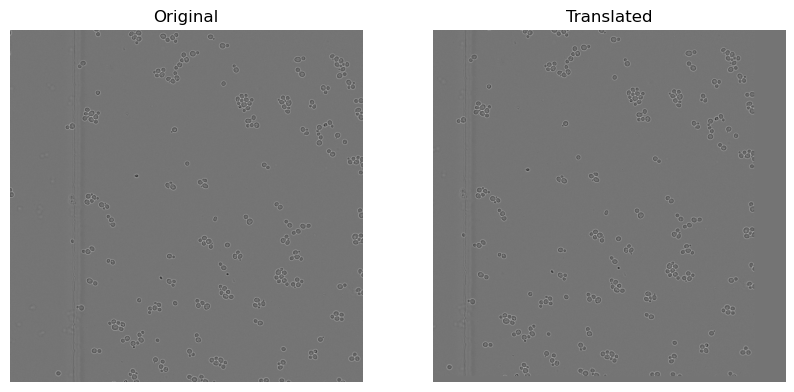

In [174]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0020.tif"
vector_temp = [-185, -36]
translate_this(image_file=i, at =vector_temp, with_plot=True)

if __name__ == "__main__":
	vector = input('What are the vector aspects {x, y}').split(sep= ", ")
	vector[0] = int(vector[0])
	vector[1] = int(vector[1])
	stop = int(input("What is the max frame to be shift"))
	folder = input("Where is the directory to be done?")
	folder = gv.slash_switch(folder)
	parallel_state = input("Should the files be shifted in parallel? [y/n]")
	if parallel_state == "y" or parallel_state == "yes" or parallel_state =="Y" or parallel_state == "Yes" or parallel_state == "YES":
		parallel_state = True
	else:
		parallel_state = False
	os.chdir(folder)
	use_cores_len = os.cpu_count()
	mini_imgIndex = miniImgIndex() #* Run search in current folder
	miniImgIndex_subset = mini_imgIndex.loc[mini_imgIndex['Frame']>= stop]

	if parallel_state:
		Parallel(n_jobs=use_cores_len, verbose = 100, prefer='threads')(delayed(translate_this)(image_file = i, at = vector, with_plot=False, gray_scale=True) for i in mini_imgIndex['File_name']) #* This should prefer threads as it largely IO limited.
	else:
		for i in mini_imgIndex['File_name']:
			translate_this(image_file= i, at = vector, with_plot=False, gray_scale=True )

In [175]:
###############################< Code modified from Medium Aricle: "Image Shifting using NumPy from Scratch" by Sameer
#* https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, fill_value): #! Check to confirm that the fill value has not changed raw_val
	vect_shape = vector.shape[:2]
	type_use = vector.dtype #* Added for variable bit depth
	if (how == 'upper') or (how == 'top'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=fill_value, dtype= type_use) #* Modified for variable bit depth
		pv = np.vstack(tup=(pp, vector))
	elif (how == 'lower') or (how == 'bottom'):
		pp = np.full(shape=(depth, vect_shape[1]), fill_value=fill_value, dtype= type_use)
		pv = np.vstack(tup=(vector, pp))
	elif (how == 'left'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=fill_value, dtype= type_use)
		pv = np.hstack(tup=(pp, vector))
	elif (how == 'right'):
		pp = np.full(shape=(vect_shape[0], depth), fill_value=fill_value, dtype= type_use)
		pv = np.hstack(tup=(vector, pp))
	else:
		return vector
	return pv

def read_this(image_file, gray_scale=True): #? This is fine
	image_src = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH) #* Modified to read in any depth
	if not gray_scale:
		image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
	return image_src

def shifter(vect, y, y_, fill_value):
	if (y > 0):
		image_trans = pad_vector(vector=vect, how='upper', depth=y_, fill_value =fill_value)
		image_trans = image_trans[:-y_,:]#.
	elif (y < 0):
		image_trans = pad_vector(vector=vect, how='lower', depth=y_, fill_value= fill_value)
		image_trans = image_trans[y_:,:]#.
	else:
		image_trans = vect
	return image_trans

def shift_image(image_src, at):
	x, y = at
	x_, y_ = abs(x), abs(y)

	fill_value = np.mean(image_src)
	if (x > 0):
		left_pad = pad_vector(vector=image_src, how='left', depth=x_, fill_value=fill_value)
		image_trans = shifter(vect=left_pad, y=y, y_=y_, fill_value = fill_value)
		image_trans = image_trans[:,:-x_]#.
	elif (x < 0):
		right_pad = pad_vector(vector=image_src, how='right', depth=x_, fill_value = fill_value)
		image_trans = shifter(vect=right_pad, y=y, y_=y_, fill_value = fill_value)
		image_trans = image_trans[:,x_:] #.
	else:
		image_trans = shifter(vect=image_src, y=y, y_=y_)

	return image_trans

def translate_this(image_file, at, with_plot=False, gray_scale=True):
	if len(at) != 2: return False

	image_src = read_this(image_file=image_file, gray_scale=gray_scale)

	if not gray_scale:
		r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
		r_trans = shift_image(image_src=r_image, at=at)
		g_trans = shift_image(image_src=g_image, at=at)
		b_trans = shift_image(image_src=b_image, at=at)
		image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
	else:
		image_trans = shift_image(image_src=image_src, at=at)


	#. Make copy
	dot = image_file.find(".")
	name = image_file[:dot]
	image_ext = image_file[dot:]
	temp_name = name + "_test" + image_ext

	cv2.imwrite(temp_name, image_trans) #. This was added to the code by Peter. Usually you would want a backup, but in this case, there are multiple stored copies of the orignal images for safety. It is easier for downstream to change the iamges in the actual "Analyze" folder

	if with_plot:
		cmap_val = None if not gray_scale else 'gray'
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

		ax1.axis("off")
		ax1.title.set_text('Original')

		ax2.axis("off")
		ax2.title.set_text("Translated")

		ax1.imshow(image_src, cmap=cmap_val)
		ax2.imshow(image_trans, cmap=cmap_val)
		return True

	return image_trans
################################################################################>

In [176]:
vect0r

NameError: name 'vect0r' is not defined

In [177]:
vector

['']

In [178]:
vector = vector_temp

In [179]:
parallel_state

False

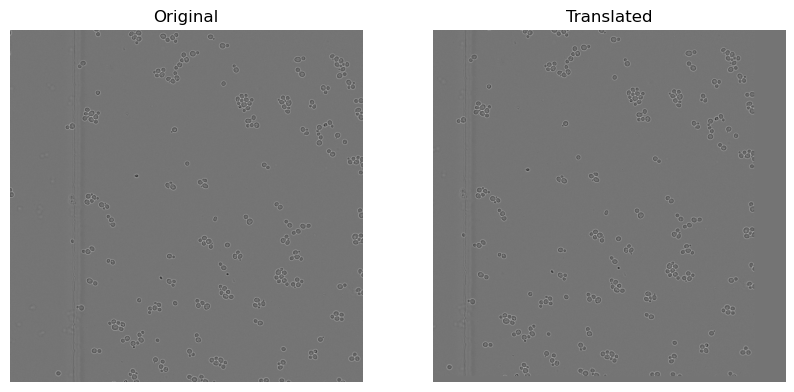

In [180]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0020.tif"
vector_temp = [-185, -36]
translate_this(image_file=i, at =vector_temp, with_plot=True)

if __name__ == "__main__":
	# vector = input('What are the vector aspects {x, y}').split(sep= ", ")
	# vector[0] = int(vector[0])
	# vector[1] = int(vector[1])
	# stop = int(input("What is the max frame to be shift"))
	# folder = input("Where is the directory to be done?")
	# folder = gv.slash_switch(folder)
	# parallel_state = input("Should the files be shifted in parallel? [y/n]")
	if parallel_state == "y" or parallel_state == "yes" or parallel_state =="Y" or parallel_state == "Yes" or parallel_state == "YES":
		parallel_state = True
	else:
		parallel_state = False
	os.chdir(folder)
	use_cores_len = os.cpu_count()
	mini_imgIndex = miniImgIndex() #* Run search in current folder
	miniImgIndex_subset = mini_imgIndex.loc[mini_imgIndex['Frame']>= stop]

	if parallel_state:
		Parallel(n_jobs=use_cores_len, verbose = 100, prefer='threads')(delayed(translate_this)(image_file = i, at = vector, with_plot=False, gray_scale=True) for i in mini_imgIndex['File_name']) #* This should prefer threads as it largely IO limited.
	else:
		for i in mini_imgIndex['File_name']:
			translate_this(image_file= i, at = vector, with_plot=False, gray_scale=True )

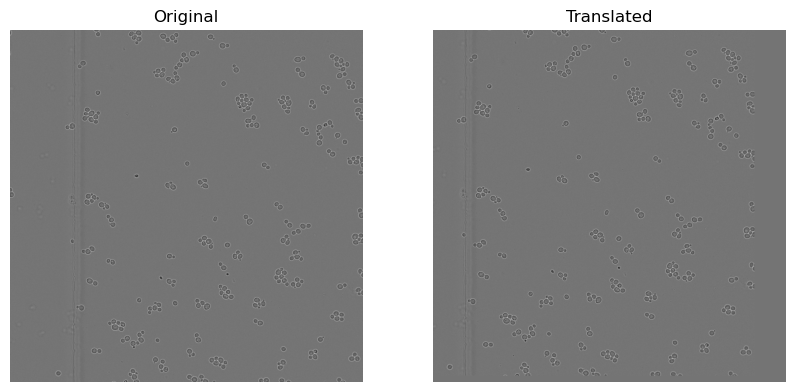

In [181]:
i = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images/Sub_position090200_time0020.tif"
vector_temp = [-183, -37]
translate_this(image_file=i, at =vector_temp, with_plot=True)

if __name__ == "__main__":
	# vector = input('What are the vector aspects {x, y}').split(sep= ", ")
	# vector[0] = int(vector[0])
	# vector[1] = int(vector[1])
	# stop = int(input("What is the max frame to be shift"))
	# folder = input("Where is the directory to be done?")
	# folder = gv.slash_switch(folder)
	# parallel_state = input("Should the files be shifted in parallel? [y/n]")
	if parallel_state == "y" or parallel_state == "yes" or parallel_state =="Y" or parallel_state == "Yes" or parallel_state == "YES":
		parallel_state = True
	else:
		parallel_state = False
	os.chdir(folder)
	use_cores_len = os.cpu_count()
	mini_imgIndex = miniImgIndex() #* Run search in current folder
	miniImgIndex_subset = mini_imgIndex.loc[mini_imgIndex['Frame']>= stop]

	if parallel_state:
		Parallel(n_jobs=use_cores_len, verbose = 100, prefer='threads')(delayed(translate_this)(image_file = i, at = vector, with_plot=False, gray_scale=True) for i in mini_imgIndex['File_name']) #* This should prefer threads as it largely IO limited.
	else:
		for i in mini_imgIndex['File_name']:
			translate_this(image_file= i, at = vector, with_plot=False, gray_scale=True )

In [182]:
print("active")

active


In [183]:
import csv
from operator import pos
from xml.etree.ElementTree import Element, SubElement, Comment, TreeBuilder, tostring
import datetime
from xml.dom import minidom
import os
import pandas as pd
import numpy as np
import datetime
import warnings
from pandas.core.indexing import IndexingError

In [184]:
imgIndex = miniImgIndex

In [185]:
imgIndex = mini_imgIndex

In [186]:
imgIndex

File_name  Frame
0   Sub_position090200_time0012.tif     12
2   Sub_position090200_time0013.tif     13
4   Sub_position090200_time0014.tif     14
6   Sub_position090200_time0015.tif     15
8   Sub_position090200_time0016.tif     16
10  Sub_position090200_time0017.tif     17
12  Sub_position090200_time0018.tif     18
14  Sub_position090200_time0019.tif     19
16  Sub_position090200_time0020.tif     20
18  Sub_position090200_time0021.tif     21
20  Sub_position090200_time0022.tif     22
22  Sub_position090200_time0023.tif     23
24  Sub_position090200_time0024.tif     24
26  Sub_position090200_time0025.tif     25
28  Sub_position090200_time0026.tif     26
30  Sub_position090200_time0027.tif     27
32  Sub_position090200_time0028.tif     28
34  Sub_position090200_time0029.tif     29
36  Sub_position090200_time0030.tif     30
38  Sub_position090200_time0031.tif     31
40  Sub_position090200_time0032.tif     32
42  Sub_position090200_time0033.tif     33
44  Sub_position090200_time0034.tif     34
46  Sub_position090200_time0035.tif     35
48  Sub_position090200_time0036.tif     36
50  Sub_position090200_time0037.tif     37
52  Sub_position090200_time0038.tif     38
54  Sub_position090200_time0039.tif     39
56  Sub_position090200_time0040.tif     40
58  Sub_position090200_time0041.tif     41
60  Sub_position090200_time0042.tif     42
62  Sub_position090200_time0043.tif     43
64  Sub_position090200_time0044.tif     44
66  Sub_position090200_time0045.tif     45
68  Sub_position090200_time0046.tif     46
70  Sub_position090200_time0047.tif     47
72  Sub_position090200_time0048.tif     48
74  Sub_position090200_time0049.tif     49
76  Sub_position090200_time0050.tif     50
78  Sub_position090200_time0051.tif     51
80  Sub_position090200_time0052.tif     52
82  Sub_position090200_time0053.tif     53
84  Sub_position090200_time0054.tif     54
86  Sub_position090200_time0055.tif     55
88  Sub_position090200_time0056.tif     56
90  Sub_position090200_time0057.tif     57

In [187]:
##Layer : Creating a file matrix with component information and matching to condition table by function
def f_lazer(z):
    start = z.find('_position')-3
    end = z.find('_position')
    return(z[start:end])

def f_Position_ID(z):
    start = z.find('_position')+9 #Note: The shift forward is dependant upon how you write out position
    end = z.find('_time')   #Make sure that the 'n' is present in the array to confirm no place 0 has been lost
    return(z[start:end])

def f_Frame(z):
    start = z.find('_time')+5
    end = z.find('_time')+9
    return(z[start:end])

def f_expdate(x):
    dstart = x.find('_hr')-4
    dend = x.find('_hr')
    expdate = x[dstart:dend]
    expdate = expdate.translate({ord('-'): None})
    expdate = "d" + expdate
    return(expdate)

def f_runnumb(d):
    rsta = d.find("hr")+2
    ren = d.find("hr")+6
    return(d[rsta:ren])

count = 0
imgIndex = []
for root, dirs, files in os.walk(os.getcwd()):
    for name in files:
        if name.endswith(".tif"):
            imgIndex.append({'Path': os.path.join(root, name)})
            count = count + 1
            print(count, end="/r")
        else :
            pass

imgIndex = pd.DataFrame(imgIndex)
imgIndex['Date'] = pd.Series(imgIndex.iloc[:,0]).apply(f_expdate)
imgIndex['PositionID'] = pd.Series(imgIndex.iloc[:,0]).apply(f_Position_ID)
imgIndex['Frame'] = pd.Series(imgIndex.iloc[:,0]).apply(f_Frame)
imgIndex['Channel'] = pd.Series(imgIndex.iloc[:,0]).apply(f_lazer)
imgIndex['Hour/Run_t'] =pd.Series(imgIndex.iloc[:,0]).apply(f_runnumb)
#imgIndex["temp_date_hour"] = imgIndex["Date"] + imgIndex["Hour/Run_t"]
imgIndex["Hour/Run_t"] = imgIndex["Hour/Run_t"].apply(pd.to_numeric)

del count
del dirs
del files
del name

z = imgIndex[["Date", "Hour/Run_t"]]
z = z.drop_duplicates().reset_index()

z["Run"] = 0
z["for"] = 1
z = z.sort_values(by = ["Date", "Hour/Run_t"], ascending = True)

for q in range(len(z)):
    r = 1
    if z.iloc[q,:]['for'] == 1:
        if z.iloc[q,1] == z.iloc[(q-1),1]:
            z.iloc[q,3] = (z.iloc[q-1,3] + 1)
            z.iloc[q,4] = 0
        else:
            z.iloc[q,3] = r
            z.iloc[q,4] = 0
    else:
        pass

z = z[["index", "Date", "Run"]] #only grab the columns which are usefull, and not the ones created just for the logical loops

t = len(z) - 1
imgIndex ["Run"] = 0
for g in range(len(z)):
    if g == 0:
        i1 = 0
        i2 = int(z.loc[g, ["index"]]) - 1
        imgIndex.loc[i1:i2, ["Run"]]  = z.iloc[g, 2]
    if g == t:
        i1 = int(z.loc[g, ["index"]])
        i2 = len(imgIndex) - 1
        imgIndex.loc[i1:i2, ["Run"]]  = z.iloc[g, 2]
    else:
        g2 = g + 1
        i1 = int(z.loc[g, ["index"]])
        i2 = int(z.loc[g2, ["index"]]) -1
        imgIndex.loc[i1:i2, ["Run"]]  = z.iloc[g, 2]
del z

imgIndex["Run"] = imgIndex["Run"].astype('str')
imgIndex["Hour/Run_t"] = imgIndex["Hour/Run_t"].astype("str")
imgIndex["Unique_pos"] = imgIndex['Date'] +"r" + imgIndex["Run"] + "p" + imgIndex['PositionID']
imgIndex["Unique_pos_hour"] = imgIndex['Date'] + "h" + imgIndex["Hour/Run_t"] + "p" + imgIndex['PositionID']
imgIndex["Unique_frame"] = imgIndex["Unique_pos"] + "f" + imgIndex['Frame'] #By performing this way, can avoid one extra step per index
imgIndex.set_index(["Unique_frame"], inplace = True)

os.chdir(microfluidics_results)
series = imgIndex["Unique_pos"]
series = pd.unique(series)
l = len(series)

with open('Positions.txt', 'a+') as posit:
	for p in series:
		posit.write(f'{p} ')
posit.close()

imgIndex.to_parquet("imgIndex.parquet")


ValueError: Unable to parse string ":\Us" at position 0

In [188]:
im

NameError: name 'im' is not defined

In [189]:
imgIndex

Path   Date PositionID Frame  \
0   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d2.ti     090200  0012   
1   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  dt.ti     090200  0012   
2   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d3.ti     090200  0013   
3   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  dt.ti     090200  0013   
4   C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d4.ti     090200  0014   
..                                                ...    ...        ...   ...   
87  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  dt.ti     090200  0055   
88  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d6.ti     090200  0056   
89  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  dt.ti     090200  0056   
90  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d7.ti     090200  0057   
91  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  dt.ti     090200  0057   

   Channel Hour/Run_t  
0      Sub       :\Us  
1      Sub       :\Us  
2      Sub       :\Us  
3      Sub       :\Us  
4      Sub       :\Us  
..     ...        ...  
87     Sub       :\Us  
88     Sub       :\Us  
89     Sub       :\Us  
90     Sub       :\Us  
91     Sub       :\Us  

[92 rows x 6 columns]

In [5]:

def f_lazer(z):
    start = z.find('_position')-3
    end = z.find('_position')
    return(z[start:end])

def f_Position_ID(z):
    start = z.find('_position')+9 #Note: The shift forward is dependant upon how you write out position
    end = z.find('_time')   #Make sure that the 'n' is present in the array to confirm no place 0 has been lost
    return(z[start:end])

def f_Frame(z):
    start = z.find('_time')+5
    end = z.find('_time')+9
    return(z[start:end])

def f_expdate(x):
    dstart = x.find('_hr')-4
    dend = x.find('_hr')
    expdate = x[dstart:dend]
    expdate = expdate.translate({ord('-'): None})
    expdate = "d" + expdate
    return(expdate)

def f_runnumb(d):
    rsta = d.find("hr")+2
    ren = d.find("hr")+6
    return(d[rsta:ren])

count = 0
imgIndex = []
for root, dirs, files in os.walk(os.getcwd()):
    for name in files:
        if name.endswith(".tif"):
            imgIndex.append({'Path': os.path.join(root, name)})
            count = count + 1
            print(count, end="/r")
        else :
            pass

imgIndex = pd.DataFrame(imgIndex)
imgIndex['Date'] = pd.Series(imgIndex.iloc[:,0]).apply(f_expdate)
imgIndex['PositionID'] = pd.Series(imgIndex.iloc[:,0]).apply(f_Position_ID)
imgIndex['Frame'] = pd.Series(imgIndex.iloc[:,0]).apply(f_Frame)
imgIndex['Channel'] = pd.Series(imgIndex.iloc[:,0]).apply(f_lazer)
imgIndex['Hour/Run_t'] =pd.Series(imgIndex.iloc[:,0]).apply(f_runnumb)
#imgIndex["temp_date_hour"] = imgIndex["Date"] + imgIndex["Hour/Run_t"]
imgIndex["Hour/Run_t"] = imgIndex["Hour/Run_t"].apply(pd.to_numeric)

del count
del dirs
del files
del name

z = imgIndex[["Date", "Hour/Run_t"]]
z = z.drop_duplicates().reset_index()

z["Run"] = 0
z["for"] = 1
z = z.sort_values(by = ["Date", "Hour/Run_t"], ascending = True)

for q in range(len(z)):
    r = 1
    if z.iloc[q,:]['for'] == 1:
        if z.iloc[q,1] == z.iloc[(q-1),1]:
            z.iloc[q,3] = (z.iloc[q-1,3] + 1)
            z.iloc[q,4] = 0
        else:
            z.iloc[q,3] = r
            z.iloc[q,4] = 0
    else:
        pass

z = z[["index", "Date", "Run"]] #only grab the columns which are usefull, and not the ones created just for the logical loops

t = len(z) - 1
imgIndex ["Run"] = 0
for g in range(len(z)):
    if g == 0:
        i1 = 0
        i2 = int(z.loc[g, ["index"]]) - 1
        imgIndex.loc[i1:i2, ["Run"]]  = z.iloc[g, 2]
    if g == t:
        i1 = int(z.loc[g, ["index"]])
        i2 = len(imgIndex) - 1
        imgIndex.loc[i1:i2, ["Run"]]  = z.iloc[g, 2]
    else:
        g2 = g + 1
        i1 = int(z.loc[g, ["index"]])
        i2 = int(z.loc[g2, ["index"]]) -1
        imgIndex.loc[i1:i2, ["Run"]]  = z.iloc[g, 2]
del z

1/r2/r3/r4/r5/r6/r7/r8/r9/r10/r11/r12/r13/r14/r15/r16/r17/r18/r19/r20/r21/r22/r23/r24/r25/r26/r27/r28/r29/r30/r31/r32/r33/r34/r35/r36/r37/r38/r39/r40/r41/r42/r43/r44/r45/r46/r47/r48/r49/r50/r51/r52/r53/r54/r55/r56/r57/r58/r59/r60/r61/r62/r63/r64/r65/r66/r67/r68/r69/r70/r71/r72/r73/r74/r75/r76/r77/r78/r79/r80/r81/r82/r83/r84/r85/r86/r87/r88/r89/r90/r91/r92/r93/r94/r95/r96/r97/r98/r99/r100/r101/r102/r103/r104/r105/r106/r107/r108/r109/r110/r111/r112/r113/r114/r115/r116/r117/r118/r119/r120/r121/r122/r123/r124/r125/r126/r127/r128/r129/r130/r131/r132/r133/r134/r135/r136/r137/r138/r139/r140/r141/r142/r143/r144/r145/r146/r147/r148/r149/r150/r151/r152/r153/r154/r155/r156/r157/r158/r159/r160/r161/r162/r163/r164/r165/r166/r167/r168/r169/r170/r171/r172/r173/r174/r175/r176/r177/r178/r179/r180/r181/r182/r183/r184/r185/r186/r187/r188/r189/r190/r191/r192/r193/r194/r195/r196/r197/r198/r199/r200/r201/r202/r203/r204/r205/r206/r207/r208/r209/r210/r211/r212/r213/r214/r215/r216/r217/r218/r219/r220/r221/r222

ValueError: Unable to parse string ":\Us" at position 0

In [7]:
os.chdir("C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix/Images")
count = 0
imgIndex = []
for root, dirs, files in os.walk(os.getcwd()):
    for name in files:
        if name.endswith(".tif"):
            imgIndex.append({'Path': os.path.join(root, name)})
            count = count + 1
            print(count, end="/r")
        else :
            pass

imgIndex = pd.DataFrame(imgIndex)

1/r2/r3/r4/r5/r6/r7/r8/r9/r10/r11/r12/r13/r14/r15/r16/r17/r18/r19/r20/r21/r22/r23/r24/r25/r26/r27/r28/r29/r30/r31/r32/r33/r34/r35/r36/r37/r38/r39/r40/r41/r42/r43/r44/r45/r46/r47/r48/r49/r50/r51/r52/r53/r54/r55/r56/r57/r58/r59/r60/r61/r62/r63/r64/r65/r66/r67/r68/r69/r70/r71/r72/r73/r74/r75/r76/r77/r78/r79/r80/r81/r82/r83/r84/r85/r86/r87/r88/r89/r90/r91/r92/r93/r94/r95/r96/r97/r98/r99/r100/r101/r102/r103/r104/r105/r106/r107/r108/r109/r110/r111/r112/r113/r114/r115/r116/r117/r118/r119/r120/r121/r122/r123/r124/r125/r126/r127/r128/r129/r130/r131/r132/r133/r134/r135/r136/r137/r138/r139/r140/r141/r142/r143/r144/r145/r146/r147/r148/r149/r150/r151/r152/r153/r154/r155/r156/r157/r158/r159/r160/r161/r162/r163/r164/r165/r166/r167/r168/r169/r170/r171/r172/r173/r174/r175/r176/r177/r178/r179/r180/r181/r182/r183/r184/r185/r186/r187/r188/r189/r190/r191/r192/r193/r194/r195/r196/r197/r198/r199/r200/r201/r202/r203/r204/r205/r206/r207/r208/r209/r210/r211/r212/r213/r214/r215/r216/r217/r218/r219/r220/r221/r222

In [8]:
imgIndex['Date'] = 'd0214'

In [9]:
imgIndex['PositionID'] = pd.Series(imgIndex.iloc[:,0]).apply(f_Position_ID)

In [10]:
imgIndex

Path   Date PositionID
0    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200
1    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200
2    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200
3    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200
4    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200
..                                                 ...    ...        ...
327  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200
328  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200
329  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200
330  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200
331  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200

[332 rows x 3 columns]

In [11]:
imgIndex['Frame'] = pd.Series(imgIndex.iloc[:,0]).apply(f_Frame)
imgIndex['Channel'] = pd.Series(imgIndex.iloc[:,0]).apply(f_lazer)

In [12]:
imgIndex

Path   Date PositionID  \
0    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
1    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
2    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
3    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
4    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
..                                                 ...    ...        ...   
327  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
328  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
329  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
330  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
331  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   

    Frame Channel  
0    0001     GFP  
1    0002     GFP  
2    0003     GFP  
3    0004     GFP  
4    0005     GFP  
..    ...     ...  
327  0079     Sub  
328  0080     Sub  
329  0081     Sub  
330  0082     Sub  
331  0083     Sub  

[332 rows x 5 columns]

In [13]:
imgIndex['Run'] = 1

In [14]:
imgIndex['Run'] = str(1)

In [15]:
imgIndex

Path   Date PositionID  \
0    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
1    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
2    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
3    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
4    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
..                                                 ...    ...        ...   
327  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
328  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
329  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
330  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
331  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   

    Frame Channel Run  
0    0001     GFP   1  
1    0002     GFP   1  
2    0003     GFP   1  
3    0004     GFP   1  
4    0005     GFP   1  
..    ...     ...  ..  
327  0079     Sub   1  
328  0080     Sub   1  
329  0081     Sub   1  
330  0082     Sub   1  
331  0083     Sub   1  

[332 rows x 6 columns]

In [16]:
imgIndex["Hour/Run_t"] = imgIndex["Hour/Run_t"].astype("str")
imgIndex["Unique_pos"] = imgIndex['Date'] +"r" + imgIndex["Run"] + "p" + imgIndex['PositionID']

KeyError: 'Hour/Run_t'

In [17]:
imgIndex

Path   Date PositionID  \
0    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
1    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
2    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
3    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
4    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
..                                                 ...    ...        ...   
327  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
328  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
329  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
330  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
331  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   

    Frame Channel Run  
0    0001     GFP   1  
1    0002     GFP   1  
2    0003     GFP   1  
3    0004     GFP   1  
4    0005     GFP   1  
..    ...     ...  ..  
327  0079     Sub   1  
328  0080     Sub   1  
329  0081     Sub   1  
330  0082     Sub   1  
331  0083     Sub   1  

[332 rows x 6 columns]

In [18]:
imgIndex["Unique_pos"] = imgIndex['Date'] +"r" + imgIndex["Run"] + "p" + imgIndex['PositionID']

In [19]:
imgIndex

Path   Date PositionID  \
0    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
1    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
2    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
3    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
4    C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
..                                                 ...    ...        ...   
327  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
328  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
329  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
330  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   
331  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214     090200   

    Frame Channel Run      Unique_pos  
0    0001     GFP   1  d0214r1p090200  
1    0002     GFP   1  d0214r1p090200  
2    0003     GFP   1  d0214r1p090200  
3    0004     GFP   1  d0214r1p090200  
4    0005     GFP   1  d0214r1p090200  
..    ...     ...  ..             ...  
327  0079     Sub   1  d0214r1p090200  
328  0080     Sub   1  d0214r1p090200  
329  0081     Sub   1  d0214r1p090200  
330  0082     Sub   1  d0214r1p090200  
331  0083     Sub   1  d0214r1p090200  

[332 rows x 7 columns]

In [20]:
imgIndex.set_index(["Unique_frame"], inplace = True)

KeyError: "None of ['Unique_frame'] are in the columns"

In [22]:
imgIndex["Unique_frame"] = imgIndex["Unique_pos"] + "f" + imgIndex['Frame'] #By performing this way, can avoid one extra step per index
imgIndex.set_index(["Unique_frame"], inplace = True)

In [206]:
os.getcwd()

"C:\\Users\\pcnba\\Grant Brown's Lab Dropbox\\Peter Bartlett\\Peter Bartlett Data\\Testing_shift_fix\\Images"

In [23]:
series = imgIndex["Unique_pos"]
series = pd.unique(series)
l = len(series)

with open('Positions.txt', 'a+') as posit:
	for p in series:
		posit.write(f'{p} ')
posit.close()

imgIndex.to_parquet("imgIndex.parquet")


In [24]:
imgIndex = pd.read_parquet('imgIndex.parquet')


In [25]:
imgIndex

Path   Date  \
Unique_frame                                                                    
d0214r1p090200f0001  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
d0214r1p090200f0002  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
d0214r1p090200f0003  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
d0214r1p090200f0004  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
d0214r1p090200f0005  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
...                                                                ...    ...   
d0214r1p090200f0079  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
d0214r1p090200f0080  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
d0214r1p090200f0081  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
d0214r1p090200f0082  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
d0214r1p090200f0083  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   

                    PositionID Frame Channel Run      Unique_pos  
Unique_frame                                                      
d0214r1p090200f0001     090200  0001     GFP   1  d0214r1p090200  
d0214r1p090200f0002     090200  0002     GFP   1  d0214r1p090200  
d0214r1p090200f0003     090200  0003     GFP   1  d0214r1p090200  
d0214r1p090200f0004     090200  0004     GFP   1  d0214r1p090200  
d0214r1p090200f0005     090200  0005     GFP   1  d0214r1p090200  
...                        ...   ...     ...  ..             ...  
d0214r1p090200f0079     090200  0079     Sub   1  d0214r1p090200  
d0214r1p090200f0080     090200  0080     Sub   1  d0214r1p090200  
d0214r1p090200f0081     090200  0081     Sub   1  d0214r1p090200  
d0214r1p090200f0082     090200  0082     Sub   1  d0214r1p090200  
d0214r1p090200f0083     090200  0083     Sub   1  d0214r1p090200  

[332 rows x 7 columns]

In [26]:
print(f"Placing results in {os.getcwd()}")
uPos_list = imgIndex["Unique_pos"].drop_duplicates()
for p in uPos_list:
    try:os.mkdir(p)
    except FileExistsError: pass
del uPos_list

Placing results in C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter Bartlett\Peter Bartlett Data\Testing_shift_fix\Images


In [27]:
Experimental_info = {'data_subset':False}

In [28]:

if Experimental_info["data_subset"] == True:
    imgIndex = imgIndex[imgIndex["Unique_pos"].isin(instances)]
else:
    pass

In [29]:
imgIndex

Path   Date  \
Unique_frame                                                                    
d0214r1p090200f0001  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
d0214r1p090200f0002  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
d0214r1p090200f0003  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
d0214r1p090200f0004  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
d0214r1p090200f0005  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
...                                                                ...    ...   
d0214r1p090200f0079  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
d0214r1p090200f0080  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
d0214r1p090200f0081  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
d0214r1p090200f0082  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   
d0214r1p090200f0083  C:\Users\pcnba\Grant Brown's Lab Dropbox\Peter...  d0214   

                    PositionID Frame Channel Run      Unique_pos  
Unique_frame                                                      
d0214r1p090200f0001     090200  0001     GFP   1  d0214r1p090200  
d0214r1p090200f0002     090200  0002     GFP   1  d0214r1p090200  
d0214r1p090200f0003     090200  0003     GFP   1  d0214r1p090200  
d0214r1p090200f0004     090200  0004     GFP   1  d0214r1p090200  
d0214r1p090200f0005     090200  0005     GFP   1  d0214r1p090200  
...                        ...   ...     ...  ..             ...  
d0214r1p090200f0079     090200  0079     Sub   1  d0214r1p090200  
d0214r1p090200f0080     090200  0080     Sub   1  d0214r1p090200  
d0214r1p090200f0081     090200  0081     Sub   1  d0214r1p090200  
d0214r1p090200f0082     090200  0082     Sub   1  d0214r1p090200  
d0214r1p090200f0083     090200  0083     Sub   1  d0214r1p090200  

[332 rows x 7 columns]

In [30]:

positions = imgIndex.reset_index()
imgIndex_T = imgIndex.reset_index()[
    ["Path", "Unique_frame", "Unique_pos", "Channel", "PositionID", "Frame"]]
positions = positions["Unique_pos"]
positions = positions.drop_duplicates()

positions
imgIndex_T

warnings.filterwarnings('ignore')
id = 1

# First, initiate the minidom root
root = minidom.Document()

# The first child is CellXFiles, create it's element,
# and then set the attributes, then append to the XML document
CellXFiles_root = root.createElement('CellXFiles')
CellXFiles_root.setAttribute('Creator', 'CellXGui')
CellXFiles_root.setAttribute('timestamp', str(now))
root.appendChild(CellXFiles_root)

for p in positions:
    # print to console to keep track which position we are working with
    print(p)

    idstr = str(id)

    # Next child is timeSeries, child of CellXFiles
    # Set attributes, append to CellXFiles
    timeSeries = root.createElement('CellXTimeSeries')
    timeSeries.setAttribute('fluotypes', 'GFP_mKO_mKa')
    # timeSeries.setAttribute('fluotypes', 'No_fluor')#no fluor
    timeSeries.setAttribute('id', idstr)
    timeSeries.setAttribute('position', '')
    timeSeries.setAttribute('tracking', '1')
    CellXFiles_root.appendChild(timeSeries)

    id = id + 1
    # Next is directory location for the output data
    # child of time series. Set attributes, append to
    # time series

    strp = str(p)
    directory = root.createElement('CellXResultDir')
    dirT = microfluidics_results+ "/" + strp
    directoryText = root.createTextNode(dirT)
    directory.appendChild(directoryText)
    timeSeries.appendChild(directory)

    # Next is the file set. This is where the for-loops will
    # probably come into play, since it looks for EACH time point
    # and this file set is a child of the timeSeries element

    pos_subset = imgIndex_T[imgIndex_T["Unique_pos"] == p]

    timepoint = np.unique(pd.to_numeric(pos_subset["Frame"], errors='coerce'))

    for i in timepoint:
        # The following will subset the dataframe to include only the
        # image paths for each channel, at the specified time point in the loopo
        pos_subset['Frame'] = pd.to_numeric(pos_subset['Frame'], errors='coerce')
        timeSubset = pos_subset[pos_subset['Frame'] == i]


        try: subImagePath = str(timeSubset[timeSubset['Channel'] == 'Sub'].iloc[0,0])
        except IndexError:
            try: subImagePath = str(timeSubset[timeSubset['Channel'] == 'out'].iloc[0,0])
            except IndexError:
                continue ## If a frame does not exist, then exit and do not create a element

        fileSet = root.createElement('CellXFileSet')
        fileSet.setAttribute('frame', str(i))
        timeSeries.appendChild(fileSet)

        # Next up is the individual channels to be appended to the fileset
        # elements, this includes all 4 channels
        brightfield = root.createElement('oofImage')

        brightfieldText = root.createTextNode(subImagePath)
        brightfield.appendChild(brightfieldText)
        fileSet.appendChild(brightfield)

        channels = ['GFP','mKO', 'mKa']

        for j in channels:
            try: channelImagePath = timeSubset[timeSubset['Channel'] == j].iloc[0,0]
            except IndexError:
                continue

            fluorophoreSet = root.createElement('fluoSet')
            fluorophoreSet.setAttribute('type', j)
            fileSet.appendChild(fluorophoreSet)


            fluorophoreImage = root.createElement('fluoImage')
            fluorophoreText = root.createTextNode(channelImagePath)
            fluorophoreImage.appendChild(fluorophoreText)
            fluorophoreSet.appendChild(fluorophoreImage)

xml_str = root.toprettyxml()
save_path_file = "Target_" + str(date_today) + ".xml"

with open(save_path_file, "w") as f:
    f.write(xml_str)


NameError: name 'warnings' is not defined

In [217]:
os.getcwd()

"C:\\Users\\pcnba\\Grant Brown's Lab Dropbox\\Peter Bartlett\\Peter Bartlett Data\\Testing_shift_fix\\Images"

In [218]:
gv.slash_switch("C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-218-83c463a6d9af>, line 1)

In [219]:
gv.slash_switch('''C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix''')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-219-9bed1dbb12ab>, line 1)

In [31]:

now = datetime.datetime.now()

if Experimental_info["data_subset"] == True:
    imgIndex = imgIndex[imgIndex["Unique_pos"].isin(instances)]
else:
    pass

positions = imgIndex.reset_index()
imgIndex_T = imgIndex.reset_index()[
    ["Path", "Unique_frame", "Unique_pos", "Channel", "PositionID", "Frame"]]
positions = positions["Unique_pos"]
positions = positions.drop_duplicates()

positions
imgIndex_T

warnings.filterwarnings('ignore')
id = 1

# First, initiate the minidom root
root = minidom.Document()

# The first child is CellXFiles, create it's element,
# and then set the attributes, then append to the XML document
CellXFiles_root = root.createElement('CellXFiles')
CellXFiles_root.setAttribute('Creator', 'CellXGui')
CellXFiles_root.setAttribute('timestamp', str(now))
root.appendChild(CellXFiles_root)

for p in positions:
    # print to console to keep track which position we are working with
    print(p)

    idstr = str(id)

    # Next child is timeSeries, child of CellXFiles
    # Set attributes, append to CellXFiles
    timeSeries = root.createElement('CellXTimeSeries')
    timeSeries.setAttribute('fluotypes', 'GFP_mKO_mKa')
    # timeSeries.setAttribute('fluotypes', 'No_fluor')#no fluor
    timeSeries.setAttribute('id', idstr)
    timeSeries.setAttribute('position', '')
    timeSeries.setAttribute('tracking', '1')
    CellXFiles_root.appendChild(timeSeries)

    id = id + 1
    # Next is directory location for the output data
    # child of time series. Set attributes, append to
    # time series

    strp = str(p)
    directory = root.createElement('CellXResultDir')
    dirT = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix"+ "/" + strp
    directoryText = root.createTextNode(dirT)
    directory.appendChild(directoryText)
    timeSeries.appendChild(directory)

    # Next is the file set. This is where the for-loops will
    # probably come into play, since it looks for EACH time point
    # and this file set is a child of the timeSeries element

    pos_subset = imgIndex_T[imgIndex_T["Unique_pos"] == p]

    timepoint = np.unique(pd.to_numeric(pos_subset["Frame"], errors='coerce'))

    for i in timepoint:
        # The following will subset the dataframe to include only the
        # image paths for each channel, at the specified time point in the loopo
        pos_subset['Frame'] = pd.to_numeric(pos_subset['Frame'], errors='coerce')
        timeSubset = pos_subset[pos_subset['Frame'] == i]


        try: subImagePath = str(timeSubset[timeSubset['Channel'] == 'Sub'].iloc[0,0])
        except IndexError:
            try: subImagePath = str(timeSubset[timeSubset['Channel'] == 'out'].iloc[0,0])
            except IndexError:
                continue ## If a frame does not exist, then exit and do not create a element

        fileSet = root.createElement('CellXFileSet')
        fileSet.setAttribute('frame', str(i))
        timeSeries.appendChild(fileSet)

        # Next up is the individual channels to be appended to the fileset
        # elements, this includes all 4 channels
        brightfield = root.createElement('oofImage')

        brightfieldText = root.createTextNode(subImagePath)
        brightfield.appendChild(brightfieldText)
        fileSet.appendChild(brightfield)

        channels = ['GFP','mKO', 'mKa']

        for j in channels:
            try: channelImagePath = timeSubset[timeSubset['Channel'] == j].iloc[0,0]
            except IndexError:
                continue

            fluorophoreSet = root.createElement('fluoSet')
            fluorophoreSet.setAttribute('type', j)
            fileSet.appendChild(fluorophoreSet)


            fluorophoreImage = root.createElement('fluoImage')
            fluorophoreText = root.createTextNode(channelImagePath)
            fluorophoreImage.appendChild(fluorophoreText)
            fluorophoreSet.appendChild(fluorophoreImage)

xml_str = root.toprettyxml()
save_path_file = "Target_" + str(date_today) + ".xml"

with open(save_path_file, "w") as f:
    f.write(xml_str)


NameError: name 'datetime' is not defined

In [221]:
datetime.data.today

AttributeError: module 'datetime' has no attribute 'data'

In [222]:
datetime.date.today

<function date.today>

In [223]:
datetime.date.today()

datetime.date(2023, 5, 17)

In [224]:
datetime.date.today()

datetime.date(2023, 5, 17)

In [225]:
datetime.datetime.today

<function datetime.today>

In [226]:
datetime.datetime.today()

datetime.datetime(2023, 5, 17, 16, 5, 37, 140896)

In [227]:
str(datetime.date.today())

'2023-05-17'

In [33]:
import datetime

now = datetime.datetime.now()
date_today = str(datetime.date.today())

if Experimental_info["data_subset"] == True:
    imgIndex = imgIndex[imgIndex["Unique_pos"].isin(instances)]
else:
    pass

positions = imgIndex.reset_index()
imgIndex_T = imgIndex.reset_index()[
    ["Path", "Unique_frame", "Unique_pos", "Channel", "PositionID", "Frame"]]
positions = positions["Unique_pos"]
positions = positions.drop_duplicates()

positions
imgIndex_T

warnings.filterwarnings('ignore')
id = 1

# First, initiate the minidom root
root = minidom.Document()

# The first child is CellXFiles, create it's element,
# and then set the attributes, then append to the XML document
CellXFiles_root = root.createElement('CellXFiles')
CellXFiles_root.setAttribute('Creator', 'CellXGui')
CellXFiles_root.setAttribute('timestamp', str(now))
root.appendChild(CellXFiles_root)

for p in positions:
    # print to console to keep track which position we are working with
    print(p)

    idstr = str(id)

    # Next child is timeSeries, child of CellXFiles
    # Set attributes, append to CellXFiles
    timeSeries = root.createElement('CellXTimeSeries')
    timeSeries.setAttribute('fluotypes', 'GFP_mKO_mKa')
    # timeSeries.setAttribute('fluotypes', 'No_fluor')#no fluor
    timeSeries.setAttribute('id', idstr)
    timeSeries.setAttribute('position', '')
    timeSeries.setAttribute('tracking', '1')
    CellXFiles_root.appendChild(timeSeries)

    id = id + 1
    # Next is directory location for the output data
    # child of time series. Set attributes, append to
    # time series

    strp = str(p)
    directory = root.createElement('CellXResultDir')
    dirT = "C:/Users/pcnba/Grant Brown's Lab Dropbox/Peter Bartlett/Peter Bartlett Data/Testing_shift_fix"+ "/" + strp
    directoryText = root.createTextNode(dirT)
    directory.appendChild(directoryText)
    timeSeries.appendChild(directory)

    # Next is the file set. This is where the for-loops will
    # probably come into play, since it looks for EACH time point
    # and this file set is a child of the timeSeries element

    pos_subset = imgIndex_T[imgIndex_T["Unique_pos"] == p]

    timepoint = np.unique(pd.to_numeric(pos_subset["Frame"], errors='coerce'))

    for i in timepoint:
        # The following will subset the dataframe to include only the
        # image paths for each channel, at the specified time point in the loopo
        pos_subset['Frame'] = pd.to_numeric(pos_subset['Frame'], errors='coerce')
        timeSubset = pos_subset[pos_subset['Frame'] == i]


        try: subImagePath = str(timeSubset[timeSubset['Channel'] == 'Sub'].iloc[0,0])
        except IndexError:
            try: subImagePath = str(timeSubset[timeSubset['Channel'] == 'out'].iloc[0,0])
            except IndexError:
                continue ## If a frame does not exist, then exit and do not create a element

        fileSet = root.createElement('CellXFileSet')
        fileSet.setAttribute('frame', str(i))
        timeSeries.appendChild(fileSet)

        # Next up is the individual channels to be appended to the fileset
        # elements, this includes all 4 channels
        brightfield = root.createElement('oofImage')

        brightfieldText = root.createTextNode(subImagePath)
        brightfield.appendChild(brightfieldText)
        fileSet.appendChild(brightfield)

        channels = ['GFP','mKO', 'mKa']

        for j in channels:
            try: channelImagePath = timeSubset[timeSubset['Channel'] == j].iloc[0,0]
            except IndexError:
                continue

            fluorophoreSet = root.createElement('fluoSet')
            fluorophoreSet.setAttribute('type', j)
            fileSet.appendChild(fluorophoreSet)


            fluorophoreImage = root.createElement('fluoImage')
            fluorophoreText = root.createTextNode(channelImagePath)
            fluorophoreImage.appendChild(fluorophoreText)
            fluorophoreSet.appendChild(fluorophoreImage)

xml_str = root.toprettyxml()
save_path_file = "Target_" + str(date_today) + ".xml"

with open(save_path_file, "w") as f:
    f.write(xml_str)


NameError: name 'datetime' is not defined